# Preparation for modeling

## Importing variables and datasets for reference

### This is needed only when you just want to access the results

**Need to run the definition of class `result` before loading this.**

In [ ]:
import pickle
Results_previous= pickle.load(open("Results.p","rb"))

In [7]:
Results_previous.keys()

dict_keys(['data_sets', 'Log_reg', 'train_scores', 'test_scores', 'LogReg_FtImp', 'rndforest_tuning', 'rndforest', 'gradBoost', 'agg_preds', 'gradBoost_feat_imp', 'rndforest_feat_imp'])

## Importing libraries

In [4]:
import pandas as pd
import numpy as np

#visualizations
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import seaborn as sns
plt.style.use('seaborn-poster')

sns.set_style('darkgrid')


#saving/loading data
import pickle

#Evaluating models
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, auc,roc_auc_score, roc_curve

#logistic regression
from sklearn.linear_model import LogisticRegression

#PCA
from sklearn.decomposition import PCA

#KNN
from sklearn.neighbors import KNeighborsClassifier


#Support Vector Machine
from sklearn.svm import SVC
#Esemble boosting methods
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

#XGboost
import xgboost as xgb

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#grid search/ cross validation
from sklearn.model_selection import GridSearchCV, cross_val_score

## Loading preprocessed data

You can see how preprocessed dataset saved in `finals.p` was created from `Data_understanding_preparation` notebook. 

In [89]:
datas = pickle.load(open("finals.p","rb"))

In [95]:
datas.keys()

dict_keys(['test_final', 'train_final', 'X_reduced', 'removed_cols', 'y', 'SMOTE_ratio', 'X_train_resampled', 'y_train_resampled', 'X_test', 'y_test', 'scaled_X_train_resampled', 'scaled_X_test', 'X_outlier', 'y_outlier', 'X'])

The datasets contains re-sampled observations and dummy variables for categorical variables. Also they are cleaned and normalized. 

In [96]:
X_train = datas['scaled_X_train_resampled']
y_train = datas['y_train_resampled']
y_test = datas['y_test']
X_test = datas['scaled_X_test']

In [97]:
y_train.value_counts()

0    57324
1    18916
Name: redemption_status, dtype: int64

Columns with id types will be removed as they should not be predicting variables. 

In [98]:
to_del =[]
for col in X_train.columns:
    if 'id' in col:
        to_del.append(col)

In [99]:
to_del

['campaign_id', 'customer_id', 'id', 'coupon_id']

In [100]:
X_train.drop(to_del, axis = 1, inplace=True)

In [101]:
X_test.drop(to_del, axis = 1, inplace=True)

## Creating a class to save different modeling results

`result` class is created to organize the model results.  

In [5]:
class result(object):
    """preds is a dictionary whose keys are 'train_preds' and 'test_preds' and the corresponding value is 
        the prediction for X_train and X_test
        
        params is a dictionary of parameters used in the model
    
    """
    def __init__(self, params=None, preds={'train_preds':None, 'test_preds':None}):
        self.params = params#parameter used, dictionary
        self.preds = preds#[train_preds, test_preds]
        self.data = None
        self.note = None
        self.metrics = None # to save the output of save_metrics
    def print_metrics(self):
        "Print evaluation scores for the train and the test sets"
        print('Train set\n')
        print("Precision Score: {}".format(precision_score(y_train, self.preds['train_preds'])))
        print("Recall Score: {}".format(recall_score(y_train, self.preds['train_preds'])))
        print("Accuracy Score: {}".format(accuracy_score(y_train, self.preds['train_preds'])))
        print("F1 Score: {}".format(f1_score(y_train, self.preds['train_preds'])))
        print('\n')
        
        print('Test set\n')
        print("Precision Score: {}".format(precision_score(y_test, self.preds['test_preds'])))
        print("Recall Score: {}".format(recall_score(y_test, self.preds['test_preds'])))
        print("Accuracy Score: {}".format(accuracy_score(y_test, self.preds['test_preds'])))
        print("F1 Score: {}".format(f1_score(y_test, self.preds['test_preds'])))
        print('\n')
        
    def save_metrics(self):
        """
            Save the evaluation scores as a dictionary.
        """
        scores ={}
        scores['Train set']={
            "Precision Score":precision_score(y_train, self.preds['train_preds']),
            "Recall Score":recall_score(y_train, self.preds['train_preds']),
            "Accuracy Score":accuracy_score(y_train, self.preds['train_preds']),
            "F1 Score":f1_score(y_train, self.preds['train_preds']),
        }

        scores['Test set']={
            "Precision Score":precision_score(y_test, self.preds['test_preds']),
            "Recall Score":recall_score(y_test, self.preds['test_preds']),
            "Accuracy Score":accuracy_score(y_test, self.preds['test_preds']),
            "F1 Score":f1_score(y_test, self.preds['test_preds']),
        }
        return scores

    def plot_confusion_matrix(self,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        """Plot confusion matrix"""
        cm = confusion_matrix(self.preds['test_preds'], y_test)
        classes =[0,1]
        # Check if normalize is set to True
        # If so, normalize the raw confusion matrix before visualizing


        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
            title ='Normalized'+ title
        else:
            print('Confusion matrix, without normalization')
            title = title
        print(cm)

        array = cm 

        df_cm = pd.DataFrame(array, index =classes,
                          columns = classes)
        plt.figure(figsize = (7,5))
#         akws = {"ha": 'left',"va": 'top'}
        akws = {"ha": 'left',"va": 'top',"size": 15}
        # Text formatting
        fmt = '.2f' if normalize else 'd'
        ax = sns.heatmap(df_cm, cmap= plt.cm.Blues,  annot=True, annot_kws=akws, fmt=fmt)
        ax.set_title(title) 
        ax.set_xlabel('True label') 
        ax.set_ylabel('Predicted label')

        plt.show() 
        return cm

## Creating functions to evaluate models

I took the methods from the `result` class and defined following functions to use them without creating the object.  

In [5]:
def print_metrics(y_hat_train, y_hat_test):
    "Save the evaluation scores as a dictionary"
    print('Train set\n')
    print("Precision Score: {}".format(precision_score(y_train, y_hat_train)))
    print("Recall Score: {}".format(recall_score(y_train, y_hat_train)))
    print("Accuracy Score: {}".format(accuracy_score(y_train, y_hat_train)))
    print("F1 Score: {}".format(f1_score(y_train, y_hat_train)))
    print('\n')

    print('Test set\n')
    print("Precision Score: {}".format(precision_score(y_test, y_hat_test)))
    print("Recall Score: {}".format(recall_score(y_test, y_hat_test)))
    print("Accuracy Score: {}".format(accuracy_score(y_test, y_hat_test)))
    print("F1 Score: {}".format(f1_score(y_test, y_hat_test)))
    print('\n')

In [6]:
def save_metrics(y_hat_train, y_hat_test):
    scores ={}
    scores['Train set']={
        "Precision Score":precision_score(y_train, y_hat_train),
        "Recall Score":recall_score(y_train, y_hat_train),
        "Accuracy Score":accuracy_score(y_train, y_hat_train),
        "F1 Score":f1_score(y_train, y_hat_train),
    }

    scores['Test set']={
        "Precision Score":precision_score(y_test, y_hat_test),
        "Recall Score":recall_score(y_test, y_hat_test),
        "Accuracy Score":accuracy_score(y_test, y_hat_test),
        "F1 Score":f1_score(y_test, y_hat_test),
    }
    return scores

In [44]:
    def plot_confusion_matrix(y_hat_test,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
        cm = confusion_matrix(y_hat_test, y_test)
        classes =[0,1]
        # Check if normalize is set to True
        # If so, normalize the raw confusion matrix before visualizing
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
            title ='Normalized'+ title
        else:
            print('Confusion matrix, without normalization')
            title = title
        print(cm)


        array = cm 

        df_cm = pd.DataFrame(array, index =classes,
                          columns = classes)
        plt.figure(figsize = (7,5))
        akws = {"ha": 'left',"va": 'top',"size": 15}
#         akws = {"size": 20}

        # Text formatting
        fmt = '.2f' if normalize else 'd'
        ax = sns.heatmap(df_cm, cmap= plt.cm.Blues,  annot=True, annot_kws=akws, fmt=fmt)
        ax.set_title(title) 
        ax.set_xlabel('True label') 
        ax.set_ylabel('Predicted label')

        plt.show() 
        return cm

## Creating a function and dataframes to save model results

In [268]:
Results ={}#dictionary to save modeling results and it will be pickled for later uses

In [102]:
#saved the dataset used for modeling as a dictionary and saved in Results.
data_sets = {}
data_sets['X_train'] = X_train
data_sets['X_test'] = X_test

data_sets['y_train'] = y_train
data_sets['y_test'] = y_test

Results['data_sets'] = data_sets

### The dataframe `train_scores` and `test_scores` for model comparisons

In [270]:
#Dataframes to save evaluating scores of different models
train_scores =pd.DataFrame(columns = ['Precision Score', 'Recall Score', 'Accuracy Score', 'F1 Score'])
test_scores =pd.DataFrame(columns = ['Precision Score', 'Recall Score', 'Accuracy Score', 'F1 Score'])

`Saving_results` is created to save results from a model to the `result` object, the dataframe created above, and display results. 

In [15]:
def Saving_results(result_obj,#result objec 
                   md_obj,#model object such as LogisticRegression
                   result_name#The name of the model such as logistic regression to save it in train_scores/test_scores df
                  ):
    #for my convinience, I just used global variables, X_train, X_test, y_train, y_test, here.  
    md_obj.fit(X_train,y_train)#fit model
    train_preds = md_obj.predict(X_train)#y_train_prediction
    test_preds = md_obj.predict(X_test)#y_test_prediction
    
    result_obj.preds = {'train_preds':train_preds, 'test_preds':test_preds}#predictions grouped as a dictionary saved 
    result_obj.params = md_obj.__dict__#hyperparameters saved 
    result_obj.metrics = result_obj.save_metrics()#evaluation scores saved as a dictionary 
    result_obj.print_metrics() #print evaluation scores 
#     result_obj.plot_confusion_matrix()
    result_obj.confMat = result_obj.plot_confusion_matrix()#confusion matrix
    Results[result_name] = result_obj#the result obj saved in Results
    print('{} is saved in Results table.'.format(result_name))
    
    
    #evaluation scores saved in the dataframes
    train_scores.loc[result_name] = result_obj.metrics['Train set'] 
    test_scores.loc[result_name] = result_obj.metrics['Test set']
    
    #updating the dataframes of evalution scores
    Results['train_scores'] = train_scores
    Results['test_scores'] = test_scores
    print('train_scores dataframe is updated.\n')
    print(train_scores)
    print('\n')
    print('test_scores dataframe is updated.\n')
    print(test_scores)
    
    return None

`modelfit` function can be used to perform cross validation and print its result and/or to plot a feature importance from a model. 

In [16]:

def modelfit(model,X,y, predictors,fit=True, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the modelorithm on the data
    if fit:
        model.fit(X, y)
        
    #Predict training set:
    y_hat = model.predict(X)
    y_hat_prob = model.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(model, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("Model Report\n")
    print ("Accuracy :{}".format(accuracy_score(y.values, y_hat)))
    print ("AUC Score (Train):{}".format(roc_auc_score(y, y_hat_prob)))
    
    if performCV:
        print ("CV Score : Mean - {} | Std - {} | Min - {} | Max - {}".format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)[:10]
        fig, ax = plt.subplots()
        ax.barh(np.arange(len(feat_imp)),feat_imp.values,align ='center')
        ax.set_yticks(np.arange(len(feat_imp)))
        ax.set_yticklabels(feat_imp.index)
        ax.invert_yaxis() 
        ax.set_xlabel('Feature Importance Score')
        ax.set_title('Top 10 most important features'.title())

# Modeling

## Logistic regression

### Parameter tuning

With varied `C` value, inverse of regularization strength whose smaller values specifying stronger regularization, ROC and AUC are compared. The `solver` is kept with 'sag' which is Stochastic Average Gradient and it is known to be faster for larger datasets.  

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.8307380184361175
Precision Score: 0.029441624365482234
Recall Score: 0.7073170731707317
Accuracy Score: 0.7993158494868872
F1 Score: 0.056530214424951264
-------------------------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.8348335522037917
Precision Score: 0.031469513908401234
Recall Score: 0.6829268292682927
Accuracy Score: 

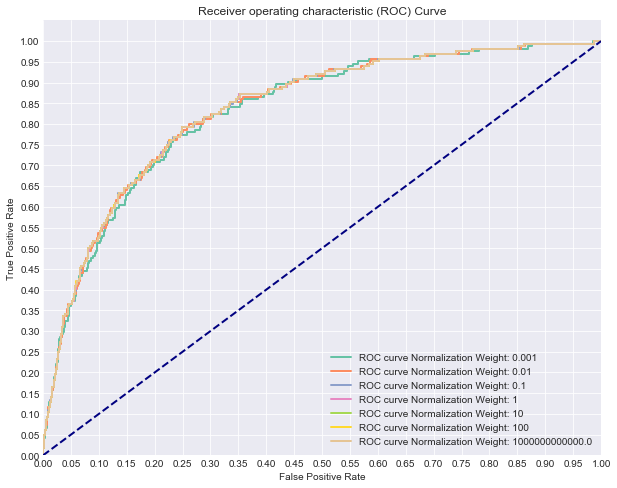

In [273]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100,1e12]
names = [0.001, 0.01, 0.1, 1, 10, 100, 1e12]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))
AUCs =[]
recalls =[]
Accuracies=[]
precisions =[]
for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='sag')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    A=auc(fpr, tpr)
    pre = precision_score(y_test, y_hat_test)
    rec = recall_score(y_test, y_hat_test)
    acc = accuracy_score(y_test, y_hat_test)
    print('AUC for {}: {}'.format(names[n], A))
    AUCs.append(A)
    print("Precision Score: {}".format(pre))
    precisions.append(pre)
    print("Recall Score: {}".format(rec))
    recalls.append(rec)
    print("Accuracy Score: {}".format(acc))
    Accuracies.append(acc)
    print("F1 Score: {}".format(f1_score(y_test, y_hat_test)))

    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

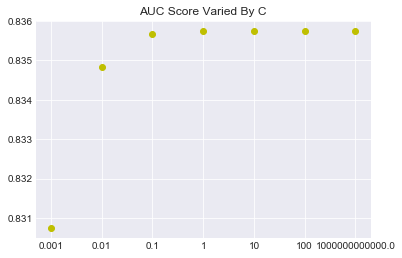

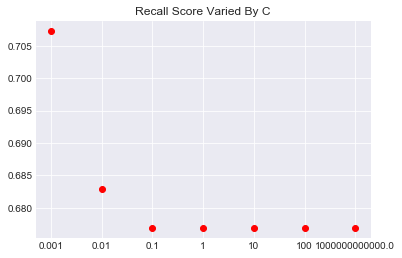

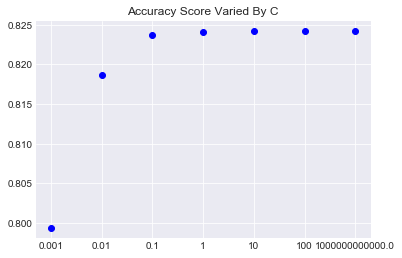

In [274]:
plt.plot(range(len(C_param_range)),AUCs,'yo')
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('AUC '+ 'score varied by C'.title())
plt.show()
plt.plot(range(len(C_param_range)), recalls, 'ro')
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('Recall score varied by C'.title())
plt.show()
plt.plot(range(len(C_param_range)), Accuracies,'bo') 
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('accuracy score varied by C'.title())
plt.show()


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 1: 0.8357336835260668
Precision Score: 0.032155272305909616
Recall Score: 0.676829268292683
Accuracy Score: 0.8240903907950659
F1 Score: 0.06139380530973451
-------------------------------------------------------
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.8307427995869086
Precision Score: 0.029441624365482234
Recall Score: 0.7073170731707317
Accuracy Score: 0.799315

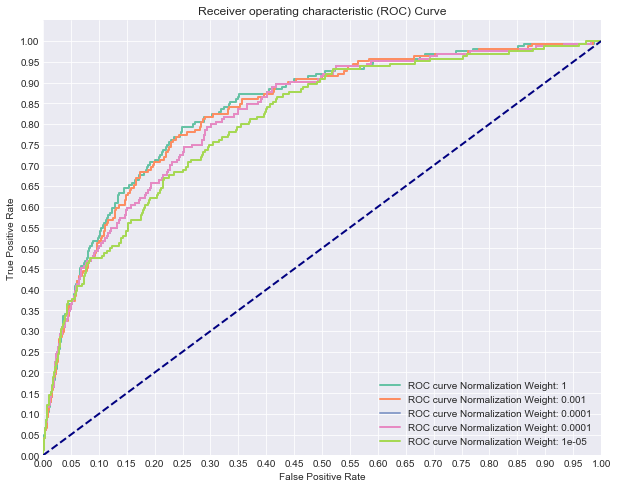

In [275]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [1,0.001, 0.0001,1e-4,1e-5]
names = [1,0.001, 0.0001,1e-4,1e-5]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))
AUCs =[]
recalls =[]
Accuracies=[]
precisions =[]
for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='sag')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    A=auc(fpr, tpr)
    pre = precision_score(y_test, y_hat_test)
    rec = recall_score(y_test, y_hat_test)
    acc = accuracy_score(y_test, y_hat_test)
    print('AUC for {}: {}'.format(names[n], A))
    AUCs.append(A)
    print("Precision Score: {}".format(pre))
    precisions.append(pre)
    print("Recall Score: {}".format(rec))
    recalls.append(rec)
    print("Accuracy Score: {}".format(acc))
    Accuracies.append(acc)
    print("F1 Score: {}".format(f1_score(y_test, y_hat_test)))

    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

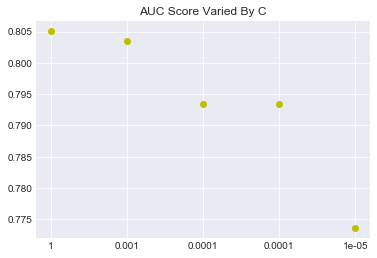

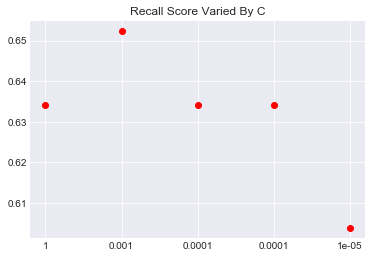

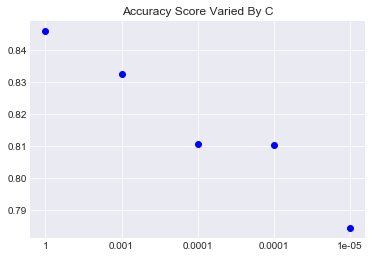

In [78]:
plt.plot(range(len(C_param_range)),AUCs,'yo')
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('AUC'+' score varied by C'.title())
plt.show()
plt.plot(range(len(C_param_range)), recalls, 'ro')
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('Recall score varied by C'.title())
plt.show()
plt.plot(range(len(C_param_range)), Accuracies,'bo') 
plt.xticks(range(len(C_param_range)),C_param_range)
plt.title('accuracy score varied by C'.title())
plt.show()


When C = 0.001, the recall score is at the highest. So we choose it as our optimal hyperparameter value. 

### Saving scores in a dataframe

Train set

Precision Score: 0.6142068097601902
Recall Score: 0.928843307253119
Accuracy Score: 0.837591815320042
F1 Score: 0.7394469929716763


Test set

Precision Score: 0.029697766097240473
Recall Score: 0.6890243902439024
Accuracy Score: 0.8060018658650357
F1 Score: 0.05694129503653313


Confusion matrix, without normalization
[[15438    51]
 [ 3692   113]]


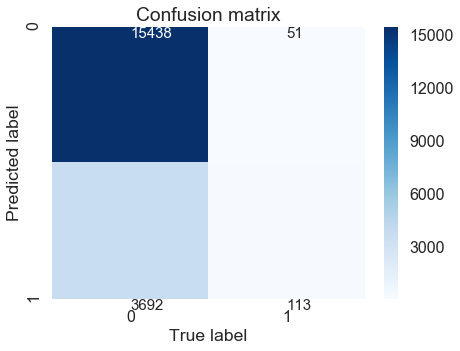

Log_reg is saved in Results table.
train_scores dataframe is updated.

                    Precision Score  Recall Score  Accuracy Score  F1 Score
LogisticRegression         0.608648      0.939099        0.835073  0.738597
RandomForest               0.897690      0.865088        0.942065  0.881088
GradientBoosting           0.998090      0.994608        0.998190  0.996346
Log_reg                    0.614207      0.928843        0.837592  0.739447
rndforest                  0.891205      0.874762        0.942432  0.882907
gradBoost                  0.998090      0.994608        0.998190  0.996346


test_scores dataframe is updated.

                    Precision Score  Recall Score  Accuracy Score  F1 Score
LogisticRegression         0.029442      0.707317        0.799316  0.056530
RandomForest               0.101987      0.469512        0.960350  0.167573
GradientBoosting           0.201754      0.140244        0.987976  0.165468
Log_reg                    0.029698      0.689024       

In [246]:
Log_reg = result()
logreg = LogisticRegression(fit_intercept=False, C=0.001, solver='sag')
Saving_results(Log_reg,logreg,'Log_reg')

In [278]:
#This is the coefficients that defines the influence of each features to predict the target. 
Log_reg.params['coef_'][0]

array([-0.04716537, -0.11459986,  0.08641258, -0.24176173,  0.06421094,
       -0.02027733, -0.11103683,  1.01767578,  0.45061133, -0.10057217,
        0.04965314,  0.01081704, -0.00249253, -0.03698229, -0.12778431,
        0.32095256,  0.12724199,  0.82828757, -0.05409624, -0.04954553,
       -0.13734426, -0.19064479, -0.13095807, -0.15103972, -0.09405255,
       -0.12970316, -0.05439384, -0.07438623, -0.50221887, -0.06990804,
       -0.09677616, -0.1162923 , -0.16767601, -0.16353037, -0.20787916,
       -0.31536518, -0.30055947, -0.19233923, -0.15002412,  0.03105813,
       -0.05491098])

In [112]:
#Create a dataframe with feture names and the coefficients
LogReg_FtImp = pd.DataFrame()
LogReg_FtImp['feature']=np.array(X_train.columns)
LogReg_FtImp['importance']= Log_reg.params['coef_'][0]

LogReg_FtImp['importance_abs'] = abs(LogReg_FtImp['importance'])#absolute values of coefficients to rank features' influences

LogReg_FtImp.sort_values(by=['importance_abs'],ascending=False, inplace=True)
LogReg_FtImp.reset_index(inplace=True)

LogReg_FtImp.drop(['index'],axis=1, inplace=True)

In [113]:
LogReg_FtImp

,feature,importance,importance_abs
0,avg_cp_use_cust,1.017307,1.017307
1,sum_cp_used,0.849982,0.849982
2,campaign_type_Y,-0.487944,0.487944
3,sum_price_cust,0.464965,0.464965
4,age_range_36-45,-0.320536,0.320536
5,age_range_46-55,-0.303544,0.303544
6,avg_price,-0.230494,0.230494
7,age_range_26-35,-0.207728,0.207728
8,age_range_56-70,-0.199456,0.199456
9,mode_cat_Meat,-0.198556,0.198556


In [290]:
#Pick top 10
set(LogReg_FtImp.feature[:10])

{'age_range_26-35',
 'age_range_36-45',
 'age_range_46-55',
 'age_range_56-70',
 'avg_cp_use_cust',
 'avg_price',
 'campaign_type_Y',
 'coupon_id',
 'sum_cp_used',
 'sum_price_cust'}

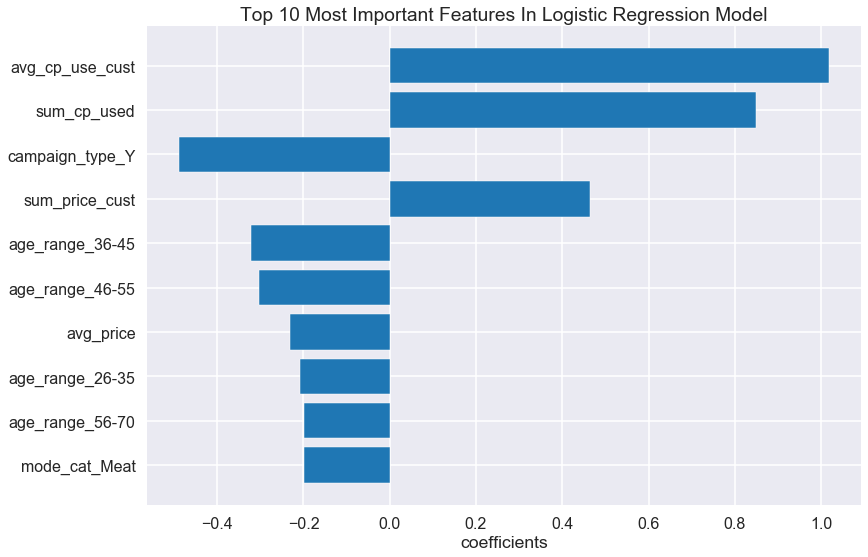

In [118]:
fig, ax = plt.subplots()
feat_imp = LogReg_FtImp.importance[:10]
ax.barh(np.arange(len(feat_imp)),feat_imp,align ='center')
ax.set_yticks(np.arange(len(feat_imp)))
ax.set_yticklabels(LogReg_FtImp.feature[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('coefficients')
ax.set_title('Top 10 most important features in logistic regression model'.title())

plt.show()

### Saving the model results to `Results` dictionary 

In [322]:
Results['LogReg_FtImp']=LogReg_FtImp

## Random Forest

In [325]:
randForest= RandomForestClassifier( max_depth=5, n_estimators=100)

In [326]:
randForest.__dict__

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'n_estimators': 100,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'min_impurity_split',
  'random_state',
  'ccp_alpha'),
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf'

In [464]:
randForest.fit(X_train,y_train)
y_hat_train = randForest.predict(X_train)
y_hat_test = randForest.predict(X_test)

Model Report

Accuracy :0.9282397691500525
AUC Score (Train):0.980344947995611
CV Score : Mean - 0.9798768231874826 | Std - 0.003952265302523254 | Min - 0.9721715771396332 | Max - 0.9831434243607554


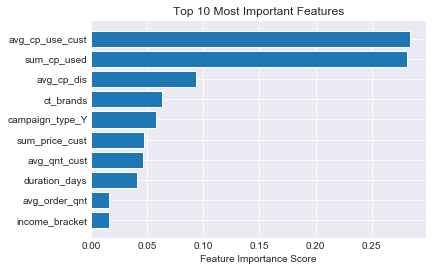

In [472]:
modelfit(randForest, X_train, y_train, X_train.columns)

In [465]:
print_metrics(y_hat_train,y_hat_test)

Train set

Precision Score: 0.9073879443585781
Recall Score: 0.7759039966166208
Accuracy Score: 0.9247507869884575
F1 Score: 0.8365107862414863


Test set

Precision Score: 0.10570469798657718
Recall Score: 0.38414634146341464
Accuracy Score: 0.9671400435368508
F1 Score: 0.16578947368421054




Confusion matrix, without normalization
[[18597   101]
 [  533    63]]


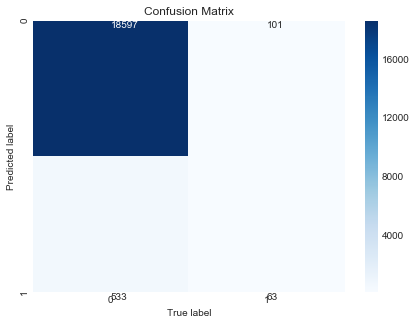

array([[18597,   101],
       [  533,    63]], dtype=int64)

In [467]:
plot_confusion_matrix(y_hat_test)
    

### Tuning hyper-parameters individually

#### Max_depth

In [28]:
X_train.shape

(85986, 41)

In [32]:
[2*x+1 for x in range(0,21)]

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41]

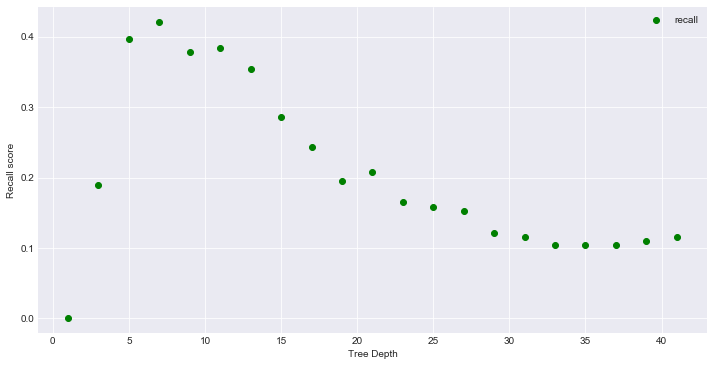

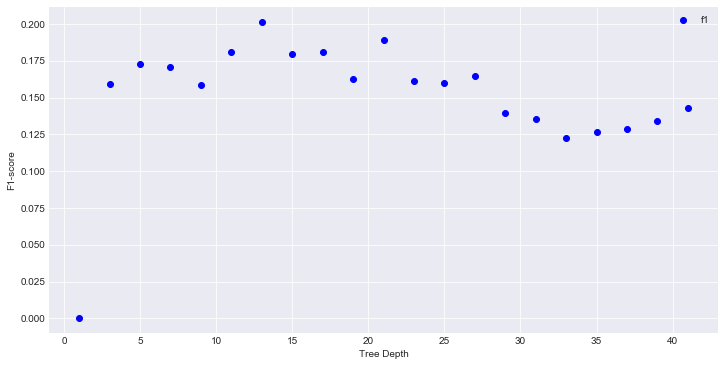

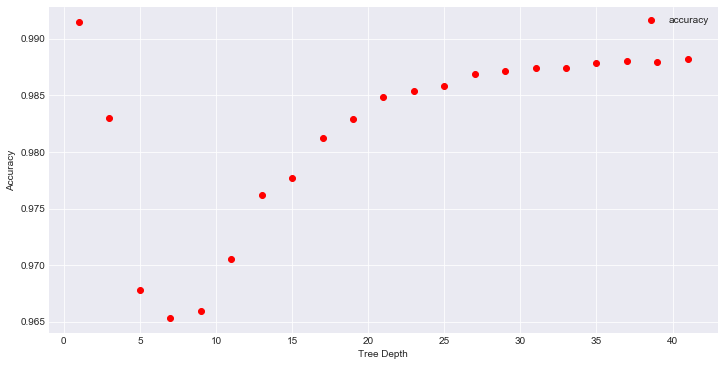

In [329]:
max_depths = [2*x+1 for x in range(0,21)]
# evaluation scores saved in lists
accuracy_results = []
f1_results = []
recall_results=[]

for max_depth in max_depths:
    forest = RandomForestClassifier(max_depth = max_depth, n_estimators =100, random_state=123)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    rec = recall_score(y_test, y_pred)
    recall_results.append(rec)
    
plt.figure(figsize =(12,6))
plt.plot(max_depths, recall_results,'go', label='recall')
plt.xlabel('Tree Depth')
plt.ylabel('Recall score')
plt.legend()
plt.show()

    
plt.figure(figsize =(12,6))
plt.plot(max_depths, f1_results,'bo', label='f1')
plt.xlabel('Tree Depth')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize = (12,6))
plt.plot(max_depths, accuracy_results,'ro', label = 'accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [334]:
#dataframe of the evaluation scores with the max_depth as its index
search_max_depths = pd.DataFrame(index = max_depths)
search_max_depths['accuracy']= accuracy_results
search_max_depths['f1_score'] =f1_results
search_max_depths['recall_score'] = recall_results

search_max_depths

,accuracy,f1_score,recall_score
1,0.991500,0.000000,0.000000
3,0.983000,0.158974,0.189024
5,0.967762,0.172872,0.396341
7,0.965274,0.170792,0.420732
9,0.965896,0.158568,0.378049
11,0.970509,0.181295,0.384146
13,0.976158,0.201389,0.353659
15,0.977713,0.179389,0.286585
17,0.981238,0.180995,0.243902
19,0.982948,0.162850,0.195122


In [335]:
#save the df in a dictionary 
rndforest_tuning={}
rndforest_tuning['search_max_depths'] = search_max_depths

The recall score is at the highest when `max_depth` is 5,7,11. 

#### min_samples_split

We will vary the min_samples_split (minimum number of samples to split) from 10% to 1% with 2% increment of the train data sample size first.  

In [336]:
[int(x*0.01*len(X_train)) for x in np.arange(1,10,2)]

[762, 2287, 3812, 5336, 6861]

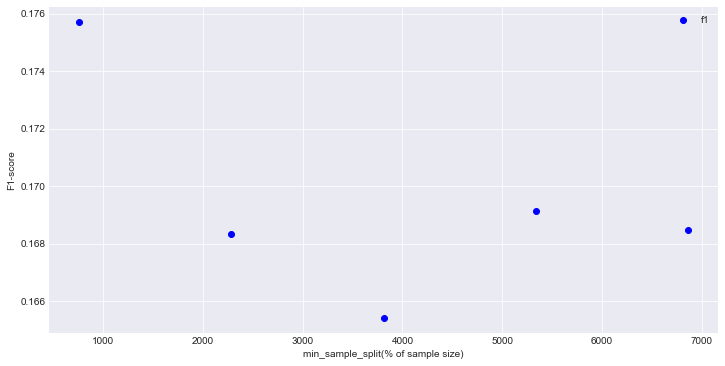

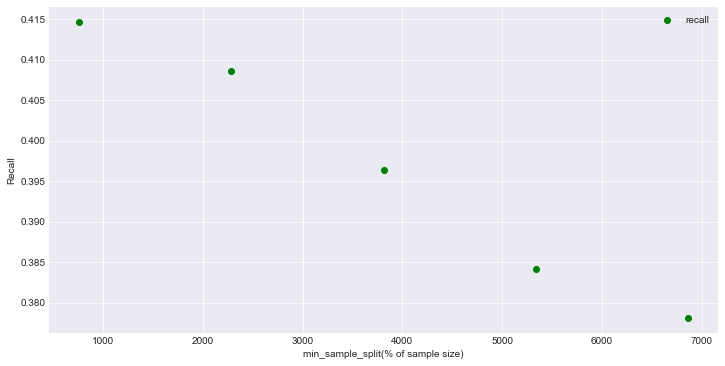

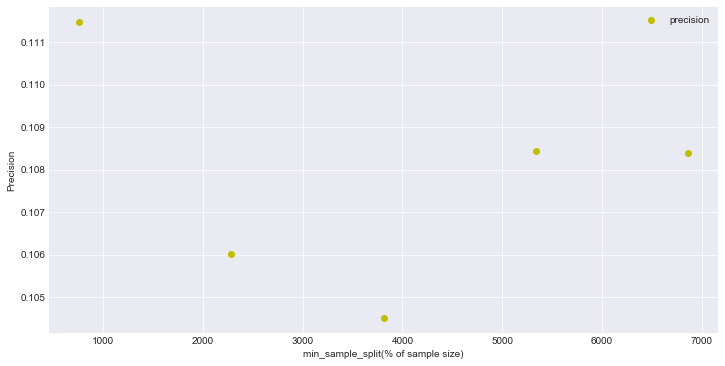

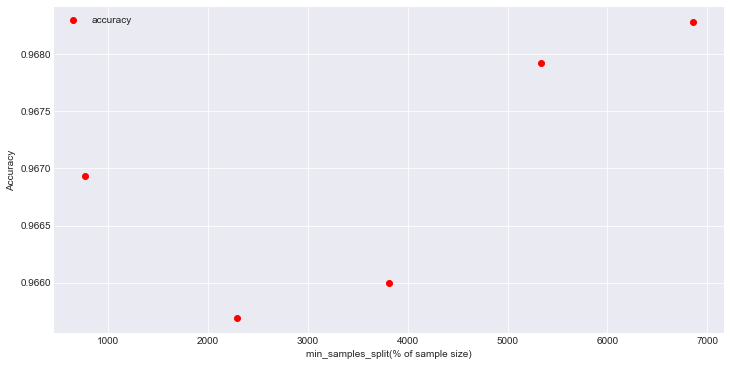

In [337]:
min_samples_splits =[int(x*0.01*len(X_train)) for x in np.arange(1,10,2)]
accuracy_results = []
f1_results = []
recall_results = []
precision_results=[]

for min_samples_split in min_samples_splits:
    forest = RandomForestClassifier(max_depth=5,min_samples_split = min_samples_split, n_estimators =100,random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)
    
plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, f1_results,'bo', label='f1')
plt.xlabel('min_sample_split(% of sample size)')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, recall_results,'go', label='recall')
plt.xlabel('min_sample_split(% of sample size)')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, precision_results,'yo', label='precision')
plt.xlabel('min_sample_split(% of sample size)')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(min_samples_splits, accuracy_results,'ro', label = 'accuracy')
plt.xlabel('min_samples_split(% of sample size)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [338]:
search_min_samples_split = pd.DataFrame(index = min_samples_splits)
search_min_samples_split['accuracy']= accuracy_results
search_min_samples_split['f1_score'] =f1_results
search_min_samples_split['recall_score'] = recall_results

search_min_samples_split

,accuracy,f1_score,recall_score
762,0.966933,0.175711,0.414634
2287,0.965689,0.168342,0.408537
3812,0.966000,0.165394,0.396341
5336,0.967917,0.169128,0.384146
6861,0.968280,0.168478,0.378049


We try the same method for 0.1% to 1% of sample sizes for `min_samples_split`.

In [339]:
[int(x*0.001*len(X_train)) for x in range(1,11)]

[76, 152, 228, 304, 381, 457, 533, 609, 686, 762]

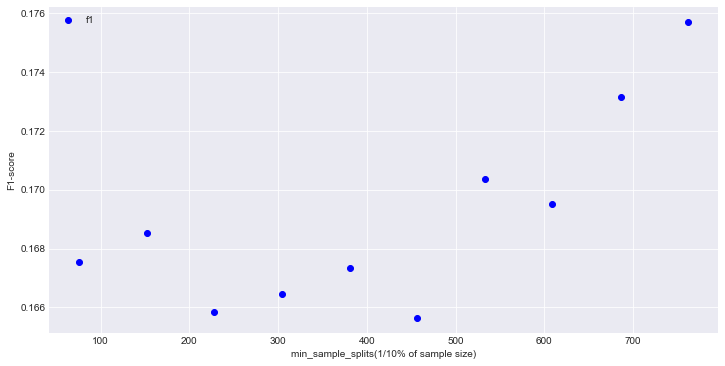

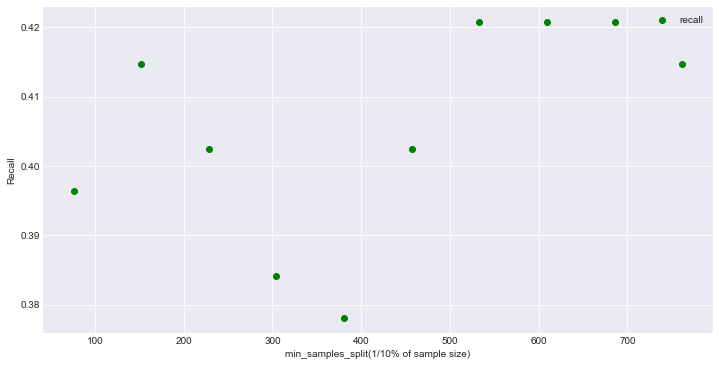

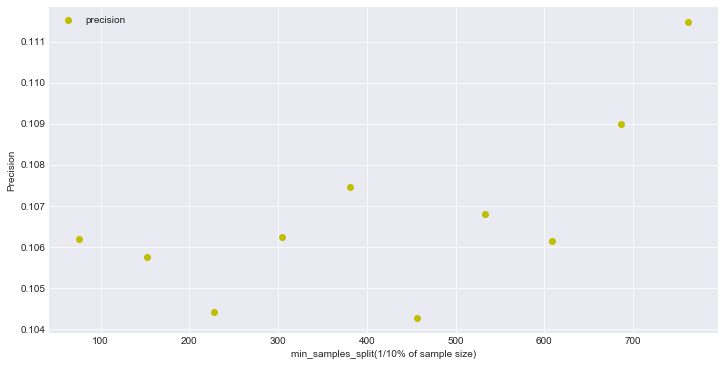

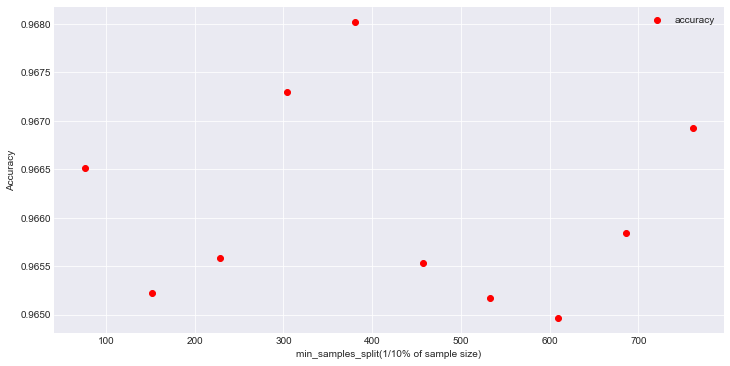

In [340]:
min_samples_splits =[int(x*0.001*len(X_train)) for x in range(1,11)]
accuracy_results = []
f1_results = []
recall_results = []
precision_results=[]

for min_samples_split in min_samples_splits:
    forest = RandomForestClassifier( max_depth=5, min_samples_split = min_samples_split, n_estimators =100,random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)
    
plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, f1_results,'bo', label='f1')
plt.xlabel('min_sample_splits(1/10% of sample size)')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, recall_results,'go', label='recall')
plt.xlabel('min_samples_split(1/10% of sample size)')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_splits, precision_results,'yo', label='precision')
plt.xlabel('min_samples_split(1/10% of sample size)')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(min_samples_splits, accuracy_results,'ro', label = 'accuracy')
plt.xlabel('min_samples_split(1/10% of sample size)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [341]:
search_min_samples_split2 = pd.DataFrame(index = min_samples_splits)
search_min_samples_split2['accuracy']= accuracy_results
search_min_samples_split2['f1_score'] =f1_results
search_min_samples_split2['recall_score'] = recall_results

search_min_samples_split2

,accuracy,f1_score,recall_score
76,0.966518,0.167526,0.396341
152,0.965222,0.168525,0.414634
228,0.965585,0.165829,0.402439
304,0.967296,0.166446,0.384146
381,0.968021,0.167341,0.378049
457,0.965533,0.165621,0.402439
533,0.965171,0.170370,0.420732
609,0.964963,0.169533,0.420732
686,0.965844,0.173149,0.420732
762,0.966933,0.175711,0.414634


In [342]:
search_min_samples_split = search_min_samples_split2.append(search_min_samples_split)

In [343]:
search_min_samples_split

,accuracy,f1_score,recall_score
76,0.966518,0.167526,0.396341
152,0.965222,0.168525,0.414634
228,0.965585,0.165829,0.402439
304,0.967296,0.166446,0.384146
381,0.968021,0.167341,0.378049
457,0.965533,0.165621,0.402439
533,0.965171,0.170370,0.420732
609,0.964963,0.169533,0.420732
686,0.965844,0.173149,0.420732
762,0.966933,0.175711,0.414634


In [345]:
search_min_samples_split.loc[[533,609,686]]

,accuracy,f1_score,recall_score
533,0.965171,0.170370,0.420732
609,0.964963,0.169533,0.420732
686,0.965844,0.173149,0.420732


`min_samples_split`:533,609,686

In [119]:
rndforest_tuning['search_min_samples_split'] = search_min_samples_split

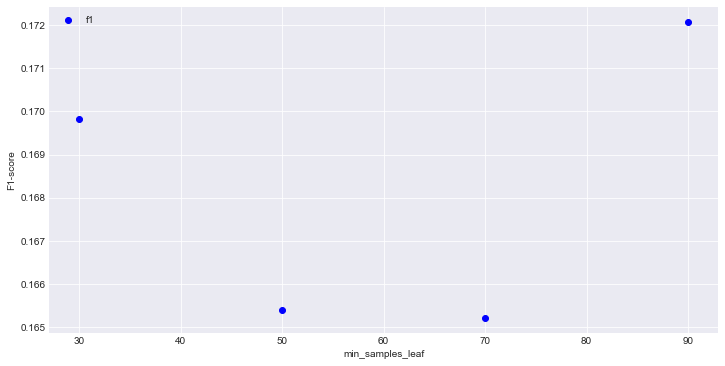

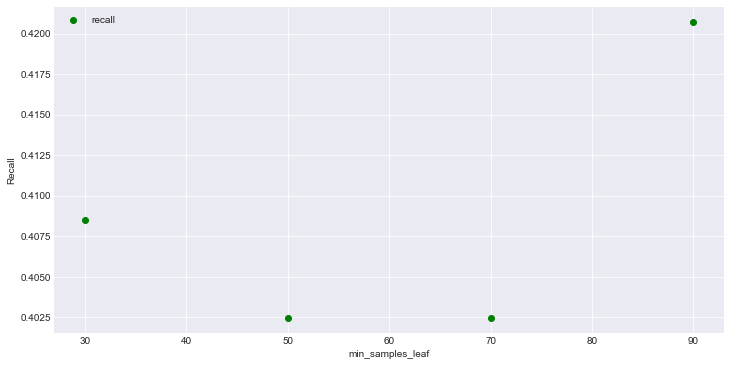

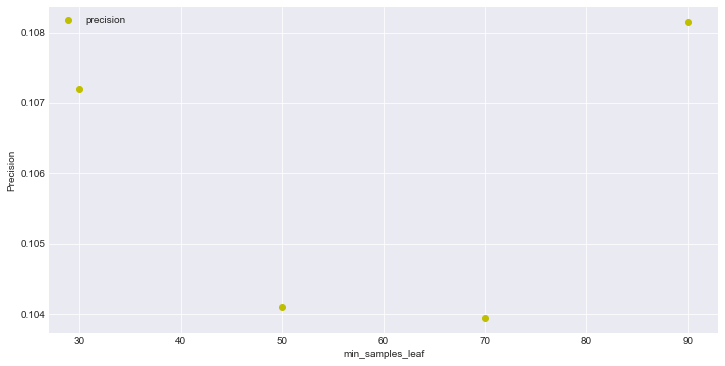

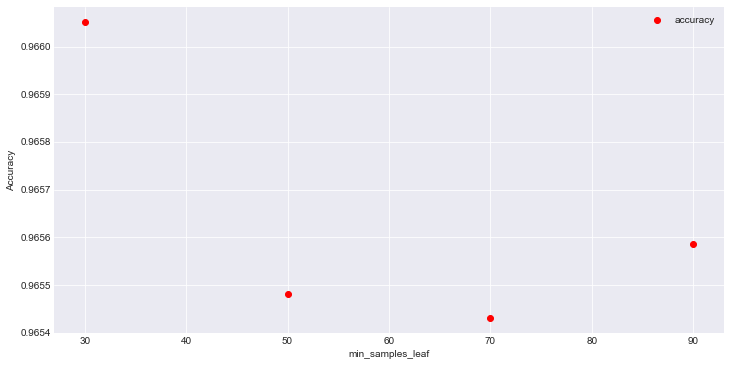

In [380]:
min_samples_leafs =[30,50,70,90]
accuracy_results = []
f1_results = []
recall_results = []
precision_results=[]

for min_samples_leaf in min_samples_leafs:
    forest = RandomForestClassifier( max_depth=5,
                                    min_samples_split=686,
                                    min_samples_leaf = min_samples_leaf,
                                    n_estimators =100,
                                    random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, f1_results,'bo', label='f1')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, recall_results,'go', label='recall')
plt.xlabel('min_samples_leaf')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, precision_results,'yo', label='precision')
plt.xlabel('min_samples_leaf')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(min_samples_leafs, accuracy_results,'ro', label = 'accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [381]:
search_min_samples_leaf = pd.DataFrame(index = min_samples_leafs)
search_min_samples_leaf['accuracy']= accuracy_results
search_min_samples_leaf['f1_score'] =f1_results
search_min_samples_leaf['recall_score'] = recall_results

search_min_samples_leaf

,accuracy,f1_score,recall_score
30,0.966052,0.169835,0.408537
50,0.965481,0.165414,0.402439
70,0.965430,0.165207,0.402439
90,0.965585,0.172070,0.420732


In [382]:
[5*x for x in range(1,7)]

[5, 10, 15, 20, 25, 30]

In [383]:
min_samples_leafs =[5*x for x in range(1,7)]


for min_samples_leaf in min_samples_leafs:
    forest = RandomForestClassifier( max_depth=5,
                                    min_samples_split=686,
                                    min_samples_leaf = min_samples_leaf,
                                    n_estimators =100,
                                    random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)
    

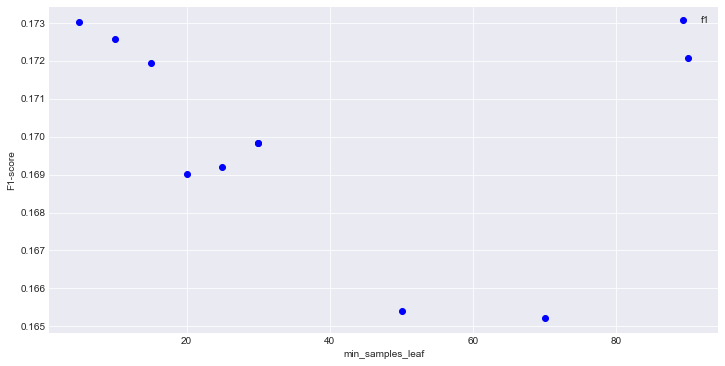

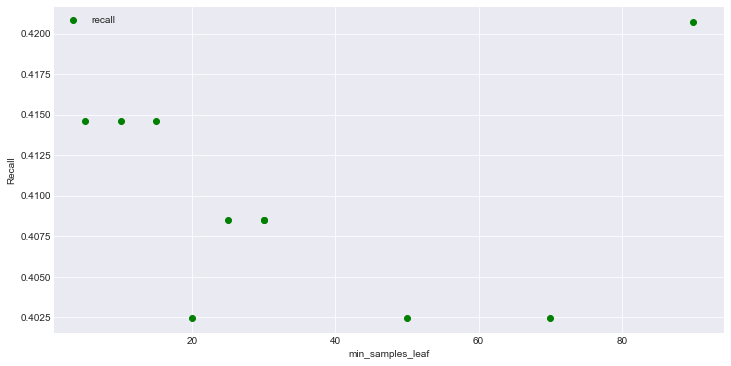

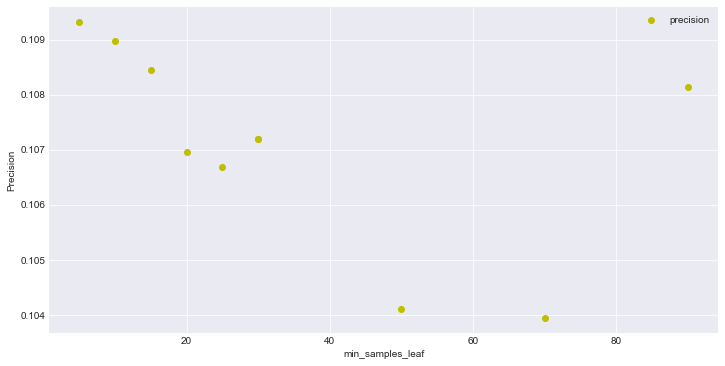

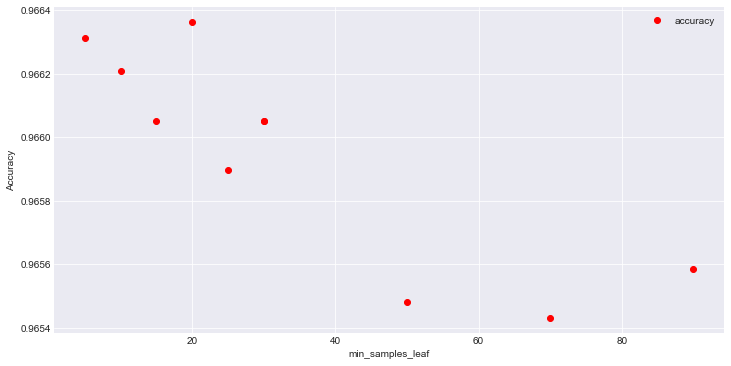

In [384]:
min_samples_leafs =[30,50,70,90]+[5*x for x in range(1,7)]

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, f1_results[:10],'bo', label='f1')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, recall_results[:10],'go', label='recall')
plt.xlabel('min_samples_leaf')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, precision_results[:10],'yo', label='precision')
plt.xlabel('min_samples_leaf')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(min_samples_leafs, accuracy_results[:10],'ro', label = 'accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [385]:
search_min_samples_leaf = pd.DataFrame()
search_min_samples_leaf['min_samples_leaf']= min_samples_leafs
search_min_samples_leaf['accuracy']= accuracy_results[:10]
search_min_samples_leaf['f1_score'] =f1_results[:10]
search_min_samples_leaf['recall_score'] = recall_results[:10]

search_min_samples_leaf

,min_samples_leaf,accuracy,f1_score,recall_score
0,30,0.966052,0.169835,0.408537
1,50,0.965481,0.165414,0.402439
2,70,0.965430,0.165207,0.402439
3,90,0.965585,0.172070,0.420732
4,5,0.966311,0.173028,0.414634
5,10,0.966207,0.172589,0.414634
6,15,0.966052,0.171934,0.414634
7,20,0.966363,0.169014,0.402439
8,25,0.965896,0.169192,0.408537
9,30,0.966052,0.169835,0.408537


In [386]:
min_samples_leafs =[90 +30*x for x in range(0,6)]


for min_samples_leaf in min_samples_leafs:
    forest = RandomForestClassifier( max_depth=5,
                                    min_samples_split=686,
                                    min_samples_leaf = min_samples_leaf,
                                    n_estimators =100,
                                    random_state=123)
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test,y_pred)
    recall_results.append(recall)
    
    precision = precision_score(y_test,y_pred)
    precision_results.append(precision)
    
    f1 = f1_score(y_test, y_pred)
    f1_results.append(f1)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)
    

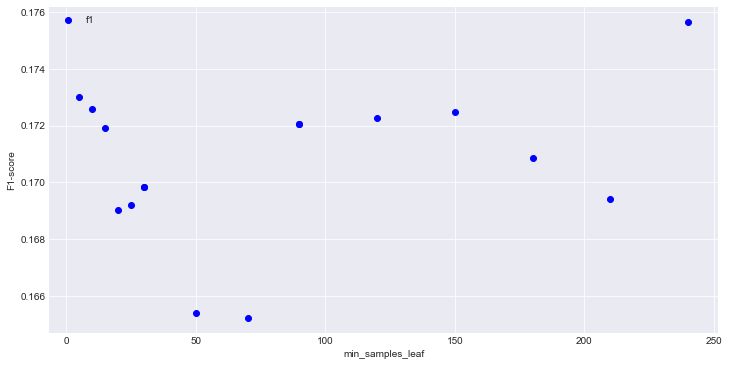

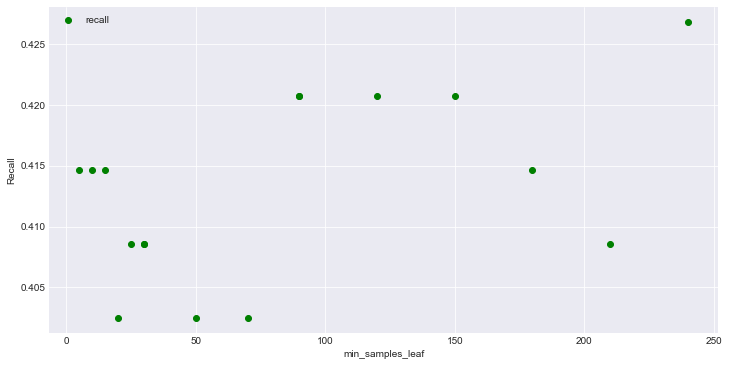

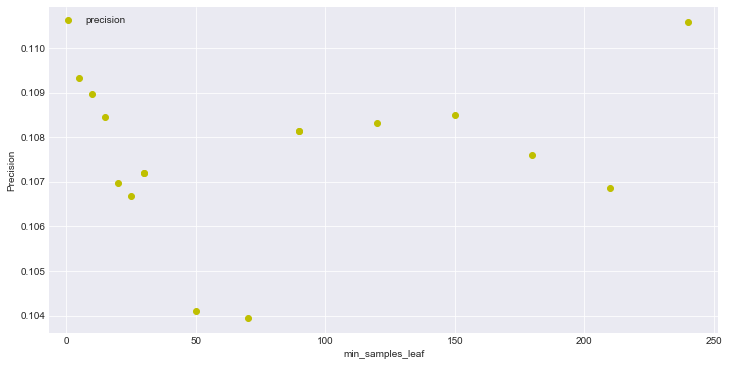

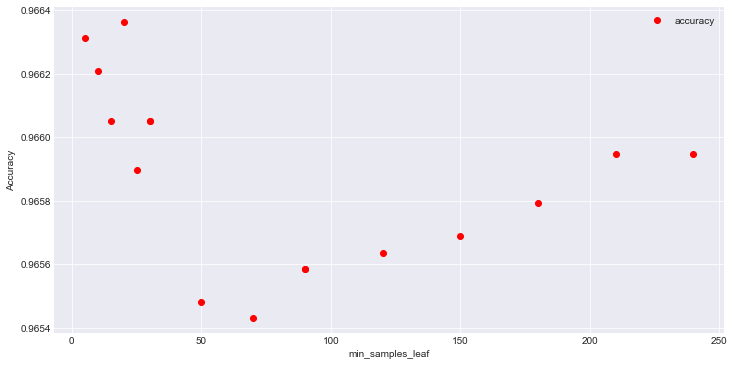

In [387]:
min_samples_leafs =[30,50,70,90]+[5*x for x in range(1,7)]+[90 +30*x for x in range(0,6)]

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, f1_results,'bo', label='f1')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, recall_results,'go', label='recall')
plt.xlabel('min_samples_leaf')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(figsize =(12,6))
plt.plot(min_samples_leafs, precision_results,'yo', label='precision')
plt.xlabel('min_samples_leaf')
plt.ylabel('Precision')
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(min_samples_leafs, accuracy_results,'ro', label = 'accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [388]:
search_min_samples_leaf = pd.DataFrame()
search_min_samples_leaf['min_samples_leaf']= min_samples_leafs
search_min_samples_leaf['accuracy']= accuracy_results
search_min_samples_leaf['f1_score'] =f1_results
search_min_samples_leaf['recall_score'] = recall_results

search_min_samples_leaf


,min_samples_leaf,accuracy,f1_score,recall_score
0,30,0.966052,0.169835,0.408537
1,50,0.965481,0.165414,0.402439
2,70,0.965430,0.165207,0.402439
3,90,0.965585,0.172070,0.420732
4,5,0.966311,0.173028,0.414634
5,10,0.966207,0.172589,0.414634
6,15,0.966052,0.171934,0.414634
7,20,0.966363,0.169014,0.402439
8,25,0.965896,0.169192,0.408537
9,30,0.966052,0.169835,0.408537


In [389]:
search_min_samples_leaf.sort_values(by=['recall_score'], inplace = True)

In [390]:
search_min_samples_leaf

,min_samples_leaf,accuracy,f1_score,recall_score
1,50,0.965481,0.165414,0.402439
2,70,0.965430,0.165207,0.402439
7,20,0.966363,0.169014,0.402439
0,30,0.966052,0.169835,0.408537
8,25,0.965896,0.169192,0.408537
9,30,0.966052,0.169835,0.408537
14,210,0.965948,0.169406,0.408537
4,5,0.966311,0.173028,0.414634
5,10,0.966207,0.172589,0.414634
6,15,0.966052,0.171934,0.414634


`min_samples_leaf` :240

In [391]:
rndforest_tuning['search_min_samples_leaf'] = search_min_samples_leaf

### Saving the collection of hyperparameters with their evaluation scores to `Results` dictionary

In [392]:
Results['rndforest_tuning'] = rndforest_tuning

### The baseline cross validation result for the random forest model 

In [393]:
forest1 = RandomForestClassifier(max_depth=5, min_samples_split=686)
mean_rf_cv_score1 = np.mean(cross_val_score(forest, X_train, y_train, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier:{:.4}%".format(mean_rf_cv_score1*100))

Mean Cross Validation Score for Random Forest Classifier:92.19%


### The optimization for the random forest model using GridsearchCV

Using the result of individual hyperparameter tuning process, we try to find the best combination of the hyperparameters.

In [394]:

forest_param_grid = {
    'n_estimators':[50,100],
    'criterion':['gini','entropy'],
    'max_depth':[5,7,11],
    'min_samples_split':[533,609,686],
    'min_samples_leaf':[240]
}
forest_grid_search = GridSearchCV(forest, forest_param_grid, cv=3)
forest_grid_search.fit(X_train, y_train)

print("Testing Accuracy: {:.4}%".format(forest_grid_search.best_score_ * 100))
print("Optimal Parameters: {}".format(forest_grid_search.best_params_))

Testing Accuracy: 93.83%
Optimal Parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 240, 'min_samples_split': 533, 'n_estimators': 50}


Model Report

Accuracy :0.9403593913955929
AUC Score (Train):0.9859828526932913
CV Score : Mean - 0.9843452011931033 | Std - 0.003531169857290451 | Min - 0.9774049305204187 | Max - 0.9869398630617221


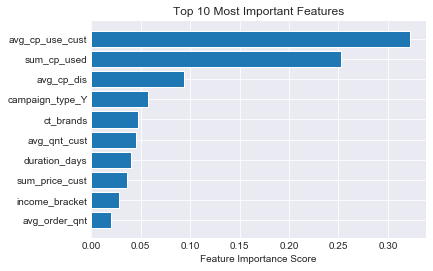

In [399]:
RNDforest = RandomForestClassifier(n_estimators=50,
                                   criterion= 'entropy',
                      max_depth=11,
                      min_samples_split=533,
                      min_samples_leaf=240)
modelfit(RNDforest, X_train, y_train, X_train.columns)

### Saving the model results in 'Results' dictionary

Train set

Precision Score: 0.8912048257661442
Recall Score: 0.8747621061535208
Accuracy Score: 0.9424317943336831
F1 Score: 0.8829069178027371


Test set

Precision Score: 0.09899749373433583
Recall Score: 0.4817073170731707
Accuracy Score: 0.9583290142013061
F1 Score: 0.16424116424116422


Confusion matrix, without normalization
[[18411    85]
 [  719    79]]


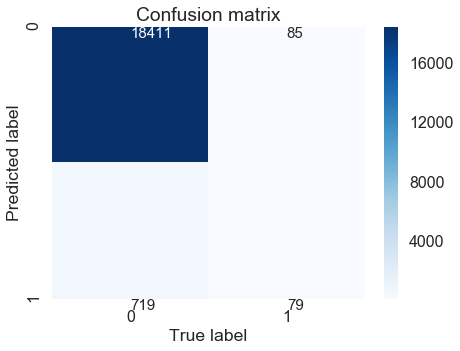

rndforest is saved in Results table.
train_scores dataframe is updated.

                    Precision Score  Recall Score  Accuracy Score  F1 Score
LogisticRegression         0.608648      0.939099        0.835073  0.738597
RandomForest               0.897690      0.865088        0.942065  0.881088
GradientBoosting           0.998090      0.994608        0.998190  0.996346
Log_reg                    0.614193      0.928790        0.837579  0.739420
rndforest                  0.891205      0.874762        0.942432  0.882907


test_scores dataframe is updated.

                    Precision Score  Recall Score  Accuracy Score  F1 Score
LogisticRegression         0.029442      0.707317        0.799316  0.056530
RandomForest               0.101987      0.469512        0.960350  0.167573
GradientBoosting           0.201754      0.140244        0.987976  0.165468
Log_reg                    0.029706      0.689024        0.806054  0.056956
rndforest                  0.098997      0.481707     

In [244]:
rndforest = result()
Saving_results(rndforest,RNDforest,'rndforest')

In [135]:
rndforest_feat_imp = pd.Series(RNDforest.feature_importances_, X_train.columns).sort_values(ascending=False)

In [138]:
Results['rndforest_feat_imp']= rndforest_feat_imp

In [139]:
Results.keys()

dict_keys(['data_sets', 'Log_reg', 'train_scores', 'test_scores', 'LogReg_FtImp', 'rndforest_tuning', 'rndforest', 'gradBoost', 'agg_preds', 'gradBoost_feat_imp', 'rndforest_feat_imp'])

## Gradient Boosting

In [402]:
gradBoost_baseline = GradientBoostingClassifier(max_depth=8,
                                                min_samples_split = 350,#0.05% of observation size
                                                min_samples_leaf = 50,
                                                max_features = 'sqrt',
                                                subsample=0.8,
                                                random_state=123)

In [403]:
gradBoost_baseline.__dict__

{'n_estimators': 100,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'criterion': 'friedman_mse',
 'min_samples_split': 350,
 'min_samples_leaf': 50,
 'min_weight_fraction_leaf': 0.0,
 'subsample': 0.8,
 'max_features': 'sqrt',
 'max_depth': 8,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'ccp_alpha': 0.0,
 'init': None,
 'random_state': 123,
 'alpha': 0.9,
 'verbose': 0,
 'max_leaf_nodes': None,
 'warm_start': False,
 'presort': 'deprecated',
 'validation_fraction': 0.1,
 'n_iter_no_change': None,
 'tol': 0.0001}

Model Report

Accuracy :0.98849685204617
AUC Score (Train):0.9990700349789665
CV Score : Mean - 0.9980368470631618 | Std - 0.002635707138056313 | Min - 0.9927710547530619 | Max - 0.9994835158412338


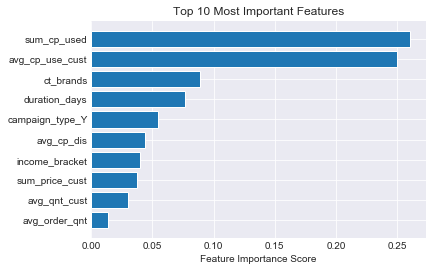

In [404]:
modelfit(gradBoost_baseline, X_train, y_train, X_train.columns)

### Tuning hyperparameters

In [405]:
param_test1 = {'n_estimators':range(20,81,10)}
gridsearch1 = GridSearchCV(estimator= gradBoost_baseline,
                      param_grid= param_test1,
                      scoring = 'recall', 
                      n_jobs= 4,
                       cv=5
                      )
gridsearch1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=350,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
    

In [406]:
 gridsearch1.best_params_, gridsearch1.best_score_

({'n_estimators': 80}, 0.962464854732896)

In [407]:
gridsearch1.cv_results_

{'mean_fit_time': array([1.36235504, 1.97431707, 2.6205698 , 3.28142033, 3.85452123,
        4.49755492, 4.98922811]),
 'std_fit_time': array([0.0151778 , 0.0190251 , 0.03666712, 0.03390607, 0.03442102,
        0.05552957, 0.09687658]),
 'mean_score_time': array([0.02035756, 0.02495303, 0.03051844, 0.03512387, 0.04009995,
        0.04509139, 0.04968705]),
 'std_score_time': array([0.00161805, 0.00062182, 0.00079728, 0.00039032, 0.00039744,
        0.00075087, 0.0009801 ]),
 'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 20},
  {'n_estimators': 30},
  {'n_estimators': 40},
  {'n_estimators': 50},
  {'n_estimators': 60},
  {'n_estimators': 70},
  {'n_estimators': 80}],
 'split0_test_score': array([0.83293682, 0.86016389, 0.86968015, 0.87708168, 0.8778747 ,
        0.87998943, 0.88395453]),
 'split1_test_score': array

In [408]:
param_test2 = {'max_depth':range(5,16,2), 
              'min_samples_split': range(200,1001, 200),
              'n_estimators':[80]}
gridsearch2 = GridSearchCV(estimator=gradBoost_baseline,
                          param_grid= param_test2,
                          scoring= 'recall',
                          n_jobs =4,
                          cv = 5)
gridsearch2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=350,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
    

In [409]:
 gridsearch2.best_params_, gridsearch2.best_score_

({'max_depth': 15, 'min_samples_split': 200, 'n_estimators': 80},
 0.9754164619844312)

In [410]:
gridsearch2.cv_results_

{'mean_fit_time': array([3.39411964, 3.43680582, 3.43082023, 3.4503684 , 3.42882676,
        4.61346879, 4.4873992 , 4.47039075, 4.41519489, 4.4145947 ,
        5.7768847 , 5.51290359, 5.37942061, 5.33664804, 5.17605405,
        6.98142438, 6.54489565, 6.28470182, 6.03660603, 5.865308  ,
        7.8508379 , 7.24559183, 7.09322376, 7.13431306, 6.66476884,
        9.00790215, 8.24992423, 7.59874153, 6.88076825, 6.63048429]),
 'std_fit_time': array([0.01455417, 0.07259528, 0.01997685, 0.02054333, 0.03095318,
        0.02839897, 0.02044457, 0.02204796, 0.00768037, 0.04218752,
        0.02411056, 0.04136748, 0.02518928, 0.05145917, 0.02826272,
        0.07343526, 0.06580664, 0.10169726, 0.06239817, 0.04674021,
        0.05855427, 0.07058466, 0.11352652, 0.0534614 , 0.06496535,
        0.0538428 , 0.1421389 , 0.06631487, 0.07508796, 0.23679942]),
 'mean_score_time': array([0.032513  , 0.03211451, 0.03192854, 0.03191428, 0.03091745,
        0.04646416, 0.04388361, 0.04348378, 0.04370279, 0.04

As `max_depth` increases, the score increases but when `min_samples_splits` decreases the score increases looking at `rank_test_score`.  

In [411]:
param_test3 = {'min_samples_leaf':range(30,71,10), 
              'min_samples_split': range(40,201,40)}
gridsearch3 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate = 0.1,
                                                                n_estimators=80,
                                                                max_depth=15,
                                                                min_samples_split = 200,
                                                                max_features = 'sqrt',
                                                                subsample=0.8,
                                                                random_state=123),
                          param_grid= param_test3,
                          scoring= 'recall',
                          n_jobs =4,
                          cv = 5)
gridsearch3.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=15,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=200,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=80,
                                                  n_iter_no_change=None,
     

In [412]:
gridsearch3.best_params_, gridsearch2.best_score_

({'min_samples_leaf': 30, 'min_samples_split': 120}, 0.9754164619844312)

In [413]:
gridsearch3.cv_results_

{'mean_fit_time': array([10.64762049, 10.15699205,  9.29740658,  8.87094421,  8.76920824,
        10.12357378, 10.02750196,  9.29875994,  8.82139425,  8.56646719,
         9.36317325,  9.34068294,  9.26134567,  9.06343637,  8.77332301,
         9.03479385,  8.99768472,  8.93254995,  8.56171207,  8.41649323,
         8.75944467,  8.71991816,  8.6468791 ,  8.54473534,  8.20811172]),
 'std_fit_time': array([0.06128244, 0.26490626, 0.04771043, 0.03223212, 0.14350766,
        0.08159776, 0.1841828 , 0.04645374, 0.03322369, 0.0647204 ,
        0.05936056, 0.02626625, 0.07332014, 0.09276403, 0.20562621,
        0.06425451, 0.02872224, 0.03833356, 0.03939808, 0.04767264,
        0.06227579, 0.05122237, 0.06379291, 0.03502842, 0.33030553]),
 'mean_score_time': array([0.0991415 , 0.0977375 , 0.09415379, 0.09194016, 0.09216676,
        0.09634233, 0.09747009, 0.09275928, 0.09076371, 0.08956022,
        0.09254642, 0.09355588, 0.09235311, 0.0907577 , 0.08936057,
        0.08956537, 0.09076285, 0.0

The optimal set of hyperparameters are :

n_estimators = 80, 

max_depth = 15, 

min_samples_split = 120, 

min_samples_leaf = 30. 

Model Report

Accuracy :0.9983473242392444
AUC Score (Train):0.9999879880936029


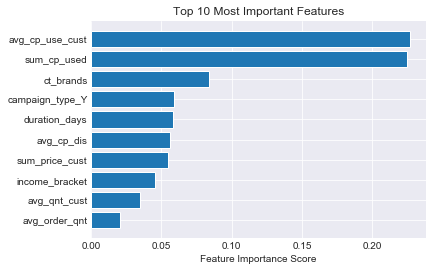

In [414]:
GR_Boost = GradientBoostingClassifier(learning_rate = 0.1,
                            n_estimators=80,
                            max_depth=15,
                            max_features = 'sqrt',
                            subsample=0.8,
                            min_samples_split=120,
                            min_samples_leaf=30,
                            random_state=123)
modelfit(GR_Boost, X_train, y_train, X_train.columns, performCV=False)

Train set

Precision Score: 0.9981442205726405
Recall Score: 0.9951892577711989
Accuracy Score: 0.9983473242392444
F1 Score: 0.9966645489199492


Test set

Precision Score: 0.21875
Recall Score: 0.17073170731707318
Accuracy Score: 0.9877682180988908
F1 Score: 0.19178082191780824


Confusion matrix, without normalization
[[19030   136]
 [  100    28]]


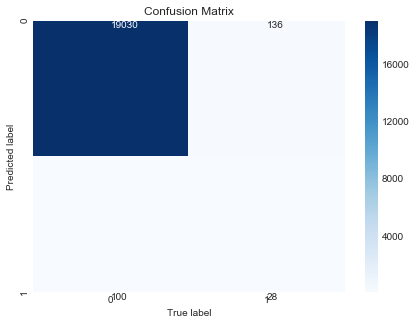

gradBoost is saved in Results table.
train_scores dataframe is updated.

           Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg           0.608648      0.939099        0.835073  0.738597
RNDforest         0.906971      0.791658        0.928161  0.845400
rndforest         0.897690      0.865088        0.942065  0.881088
gradBoost         0.998144      0.995189        0.998347  0.996665


test_scores dataframe is updated.

           Precision Score  Recall Score  Accuracy Score  F1 Score
Log_reg           0.029442      0.707317        0.799316  0.056530
RNDforest         0.108320      0.420732        0.965637  0.172285
rndforest         0.101987      0.469512        0.960350  0.167573
gradBoost         0.218750      0.170732        0.987768  0.191781


In [415]:
# Saving_results(result_obj, md_obj,result_name)
gradBoost = result()
Saving_results(gradBoost,GR_Boost,'gradBoost')

In [417]:
grd_boost4 = GradientBoostingClassifier(learning_rate = 0.1,
                            n_estimators=80,
                            max_depth=15,
                            max_features = 'sqrt',
                            subsample=0.8,
                            min_samples_split=120,
                            min_samples_leaf=30,
                            random_state=123)
param_test4 = {'subsample':[0.6+0.05*x for x in range(0,7)]}
gridsearch4 = GridSearchCV(estimator=grd_boost4,
                           param_grid= param_test4,
                          scoring='recall',n_jobs=4,iid=False, cv=5)
gridsearch4.fit(X_train,y_train)
gridsearch4.best_params_, gridsearch4.best_score_


C:\Users\woogu\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'subsample': 0.8}, 0.976949608770515)

As final tuning process, the learning rate is decreased as a half and, to compensate the small step size for the gradient, the number of trees are doubled.   

Model Report

Accuracy :0.998189926547744
AUC Score (Train):0.9999880876932875
CV Score : Mean - 0.999146137853981 | Std - 0.0015810234919766532 | Min - 0.9959841806119809 | Max - 0.9999580144791254


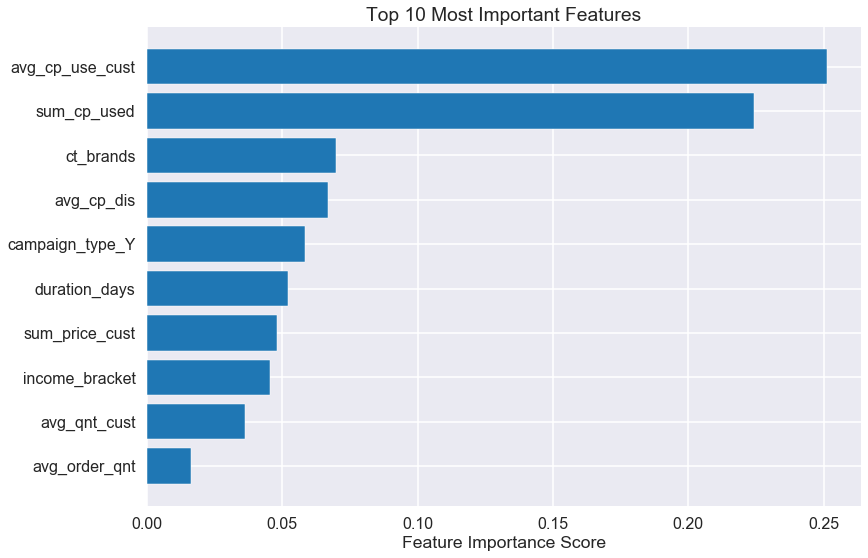

In [104]:
grd_boost4 = GradientBoostingClassifier(learning_rate = 0.05,
                            n_estimators=160,
                            max_depth=15,
                            max_features = 'sqrt',
                            subsample=0.8,
                            min_samples_split=120,
                            min_samples_leaf=30,
                            random_state=123)
modelfit(grd_boost4,X_train,y_train, X_train.columns)

### Saving the model result in `Results` dictionary

Train set

Precision Score: 0.9980901856763926
Recall Score: 0.9946077394798054
Accuracy Score: 0.998189926547744
F1 Score: 0.9963459196102314


Test set

Precision Score: 0.20175438596491227
Recall Score: 0.1402439024390244
Accuracy Score: 0.9879755364361977
F1 Score: 0.16546762589928057


Confusion matrix, without normalization
[[19039   141]
 [   91    23]]


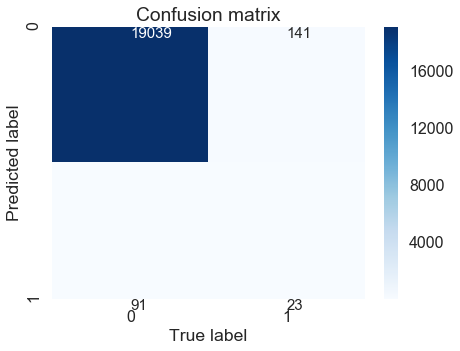

gradBoost is saved in Results table.
train_scores dataframe is updated.

                    Precision Score  Recall Score  Accuracy Score  F1 Score
LogisticRegression         0.608648      0.939099        0.835073  0.738597
RandomForest               0.897690      0.865088        0.942065  0.881088
GradientBoosting           0.998090      0.994608        0.998190  0.996346
Log_reg                    0.614193      0.928790        0.837579  0.739420
rndforest                  0.891205      0.874762        0.942432  0.882907
gradBoost                  0.998090      0.994608        0.998190  0.996346


test_scores dataframe is updated.

                    Precision Score  Recall Score  Accuracy Score  F1 Score
LogisticRegression         0.029442      0.707317        0.799316  0.056530
RandomForest               0.101987      0.469512        0.960350  0.167573
GradientBoosting           0.201754      0.140244        0.987976  0.165468
Log_reg                    0.029706      0.689024     

In [245]:
# Saving_results(result_obj, md_obj,result_name)
gradBoost = result()
Saving_results(gradBoost,grd_boost4,'gradBoost')

In [125]:
gradBoost_feat_imp = pd.Series(grd_boost4.feature_importances_, X_train.columns).sort_values(ascending=False)

In [126]:
Results['gradBoost_feat_imp']=gradBoost_feat_imp

# Aggregating results (predictions) of three models

Here, the predicted target values from three models were averaged to see if this aggregation model performs better. 

In [11]:
test= rndforest.preds['test_preds']+gradBoost.preds['test_preds']+Log_reg.preds['test_preds']
#if value=3 all models agree that it is predicted a positive class
#if value = 2 then two models predicts to be a positive and one model disgrees
#if value =1 then two models predicts to be a negative and one model disgrees
#if value=0 all models agree that it is predicted a negative class

In [18]:
sum(test>2)

95

In [33]:
def avg(n):
    #change the sum value to binary using average value 
    if 1/3*n>0.5:
        return 1
    else:
        return 0

avg_preds = map(avg, test)


In [34]:
agg_preds =pd.Series(avg_preds)

Confusion matrix, without normalization
[[18621    97]
 [  509    67]]


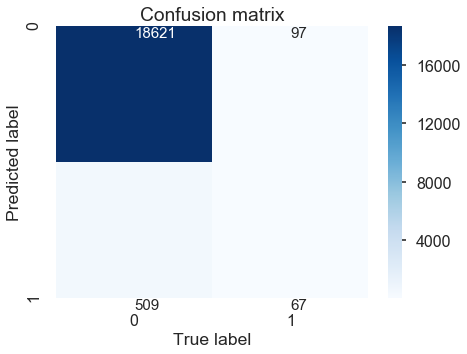

In [46]:
agg_preds_cm = plot_confusion_matrix(agg_preds)

In [41]:
acc=(confusion_matrix(y_test,agg_preds)[0][0]+confusion_matrix(y_test,agg_preds)[1][1])/len(y_test)*100
print('{}% accuracy'.format(round(acc,2)))

96.86% accuracy


In [421]:
rndforest.__dict__['confMat']

array([[18452,    87],
       [  678,    77]], dtype=int64)

In [422]:
gradBoost.__dict__['confMat']

array([[19039,   141],
       [   91,    23]], dtype=int64)

In [423]:
Log_reg.__dict__['confMat']

array([[15306,    48],
       [ 3824,   116]], dtype=int64)

The aggregated model performs better than all three models except the recall score is lower than the random forest model. This might be the best model for prediction. 

In [488]:
Results['agg_preds']= agg_preds

# Analyzing model results 

In [81]:
model_names =['LogisticRegression','RandomForest', 'GradientBoosting']

In [88]:
train_scores.index = model_names
train_scores

,Precision Score,Recall Score,Accuracy Score,F1 Score
LogisticRegression,0.608648,0.939099,0.835073,0.738597
RandomForest,0.897690,0.865088,0.942065,0.881088
GradientBoosting,0.998090,0.994608,0.998190,0.996346


In [87]:
test_scores.index = model_names
test_scores

,Precision Score,Recall Score,Accuracy Score,F1 Score
LogisticRegression,0.029442,0.707317,0.799316,0.056530
RandomForest,0.101987,0.469512,0.960350,0.167573
GradientBoosting,0.201754,0.140244,0.987976,0.165468


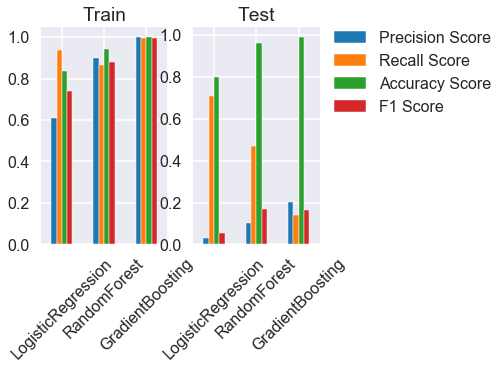

In [92]:
fig, axes = plt.subplots(1,2,figsize=(5,4))
train_scores.plot.bar(ax= axes[0])
axes[0].get_legend().remove()
axes[0].tick_params(axis='x',rotation=45)
axes[0].set_title('Train')

test_scores.plot.bar(ax= axes[1])
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 0.95,5,0.1))
axes[1].tick_params(axis='x',rotation=45)
axes[1].set_title('Test')
plt.show()
# plt.legend(show=False)

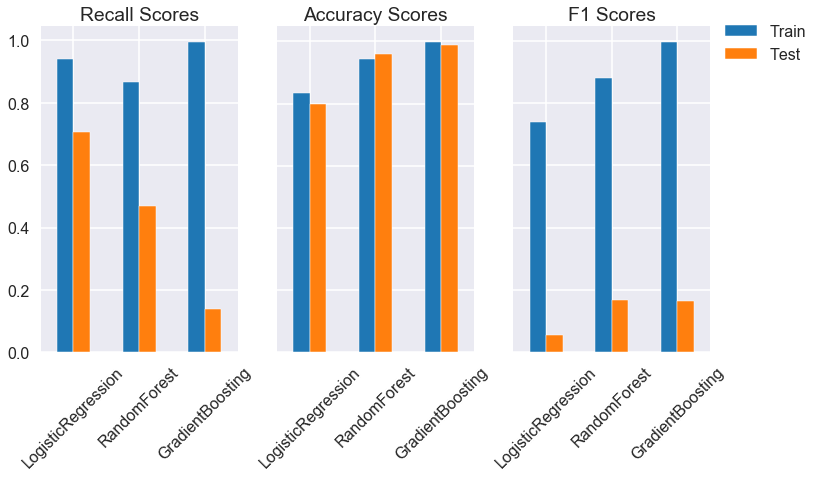

In [94]:

recall_plot = pd.DataFrame([train_scores['Recall Score'],test_scores['Recall Score']], index=['Train','Test'])
acc_plot = pd.DataFrame([train_scores['Accuracy Score'],test_scores['Accuracy Score']], index=['Train','Test'])
f1_plot = pd.DataFrame([train_scores['F1 Score'],test_scores['F1 Score']], index=['Train','Test'])

ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

recall_plot.T.plot.bar(ax=ax1, figsize=(12,6))
ax1.set_title('Recall Scores')
# ax1.legend(loc='upper left')
ax1.tick_params(axis='x',rotation=45)
ax1.get_legend().remove()

acc_plot.T.plot.bar(ax=ax2, sharey=True)
ax2.set_title('Accuracy Scores')
ax2.get_legend().remove()
ax2.tick_params(axis='x',rotation=45)

f1_plot.T.plot.bar(ax=ax3, sharey=True)
ax3.set_title('F1 Scores')
ax3.legend(loc='upper left', bbox_to_anchor=(1, 0.95,5,0.1))
ax3.tick_params(axis='x',rotation=45)

In [141]:
Results.keys()

dict_keys(['data_sets', 'Log_reg', 'train_scores', 'test_scores', 'LogReg_FtImp', 'rndforest_tuning', 'rndforest', 'gradBoost', 'agg_preds', 'gradBoost_feat_imp', 'rndforest_feat_imp'])

In [105]:
gradBoost_feat_imp = pd.DataFrame(gradBoost_feat_imp).reset_index()
gradBoost_feat_imp.columns =['feature', 'score']

In [106]:
rndforest_feat_imp = pd.DataFrame(rndforest_feat_imp).reset_index()
rndforest_feat_imp.columns =['feature', 'score']

In [153]:
ranks = pd.concat([LogReg_FtImp, gradBoost_feat_imp,rndforest_feat_imp], axis=1)

In [154]:
ranks[:10]

,feature,importance,importance_abs,feature,score,feature,score
0,avg_cp_use_cust,1.017307,1.017307,avg_cp_use_cust,0.251224,avg_cp_use_cust,0.310140
1,sum_cp_used,0.849982,0.849982,sum_cp_used,0.224201,sum_cp_used,0.271541
2,campaign_type_Y,-0.487944,0.487944,ct_brands,0.070051,avg_cp_dis,0.091800
3,sum_price_cust,0.464965,0.464965,avg_cp_dis,0.067047,campaign_type_Y,0.066653
4,age_range_36-45,-0.320536,0.320536,campaign_type_Y,0.058315,sum_price_cust,0.048473
5,age_range_46-55,-0.303544,0.303544,duration_days,0.052053,avg_qnt_cust,0.039080
6,avg_price,-0.230494,0.230494,sum_price_cust,0.048221,duration_days,0.038769
7,age_range_26-35,-0.207728,0.207728,income_bracket,0.045329,ct_brands,0.029165
8,age_range_56-70,-0.199456,0.199456,avg_qnt_cust,0.036103,income_bracket,0.028219
9,mode_cat_Meat,-0.198556,0.198556,avg_order_qnt,0.016282,avg_order_qnt,0.017488


In [158]:
#calculating how features the top 10 list share
ranks = list(LogReg_FtImp.feature[:10]) + list(gradBoost_feat_imp.feature[:10]) +list(rndforest_feat_imp[:10])
len(set(ranks))

18

In [62]:
#rename the top 10 features to make them more readable 
Log_ft =['mean coupon usages per customer',
        'total counts of coupon usage',
        'campagin type Y', 
        'total amount customer spent',
        'age range between 36 and 45',
        'age range between 46 and 55',
        'mean item price that the coupon is applicable',
       'age range between 26 and 35',
        'age range between 56 and 70',
        'coupon applicable mostly on the meat category'] 
        

In [64]:
LogReg_FtImp = Results_previous['LogReg_FtImp']
gradBoost_feat_imp=Results_previous['gradBoost_feat_imp']
rndforest_feat_imp=Results_previous['rndforest_feat_imp']

In [65]:
feature_names = dict(zip(LogReg_FtImp.feature[:10], Log_ft))

In [66]:
#dictionary to match old names to new names 
feature_names

{'avg_cp_use_cust': 'mean coupon usages per customer',
 'sum_cp_used': 'total counts of coupon usage',
 'campaign_type_Y': 'campagin type Y',
 'sum_price_cust': 'total amount customer spent',
 'age_range_36-45': 'age range between 36 and 45',
 'age_range_46-55': 'age range between 46 and 55',
 'avg_price': 'mean item price that the coupon is applicable',
 'age_range_26-35': 'age range between 26 and 35',
 'age_range_56-70': 'age range between 56 and 70',
 'mode_cat_Meat': 'coupon applicable mostly on the meat category'}

In [67]:
#collecting the feature names not in the feature_names but in the top 10 lists in the gradient boosting model
fts =[]
for feature in gradBoost_feat_imp.feature[:10]:
    if feature not in list(LogReg_FtImp.feature[:10]):
        fts.append(feature)

In [68]:
fts

['ct_brands',
 'avg_cp_dis',
 'duration_days',
 'income_bracket',
 'avg_qnt_cust',
 'avg_order_qnt']

In [69]:
for feature in gradBoost_feat_imp.feature[:10]:
    if feature not in list(rndforest_feat_imp.feature[:10]):
        print(feature)

In [70]:
names =['number of brands covered by coupon',
       'mean coupon discount', 
       'lengh in days of promotion',
       'customer income bracket',
       'mean quantity ordered by customer',
       'average quantity ordered covered by coupon']

In [71]:
#another dictionary to match the old to the new
feature_names2 = dict(zip(fts,names))

In [72]:
LogReg_FtImp.replace(feature_names).feature[:10]

0                  mean coupon usages per customer
1                     total counts of coupon usage
2                                  campagin type Y
3                      total amount customer spent
4                      age range between 36 and 45
5                      age range between 46 and 55
6    mean item price that the coupon is applicable
7                      age range between 26 and 35
8                      age range between 56 and 70
9    coupon applicable mostly on the meat category
Name: feature, dtype: object

In [76]:
feature_names.update(feature_names2)

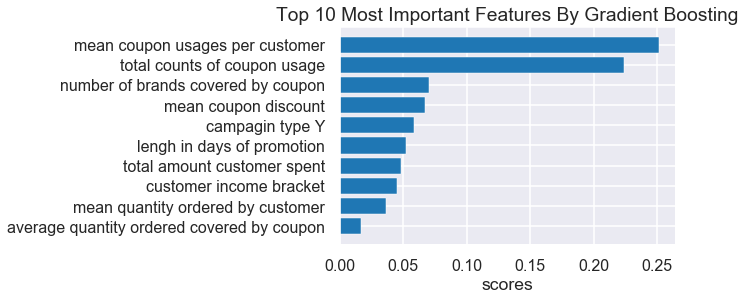

In [81]:
#making new plots with easier names
fig, ax = plt.subplots()
feat_imp = gradBoost_feat_imp.score[:10]
ax.barh(np.arange(len(feat_imp)),feat_imp,align ='center')
ax.set_yticks(np.arange(len(feat_imp)))
ax.set_yticklabels(gradBoost_feat_imp.replace(feature_names).feature[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('scores')
ax.set_title('Top 10 most important features by gradient boosting'.title())

plt.show()
# plt.ylabel('Feature Importance Score')

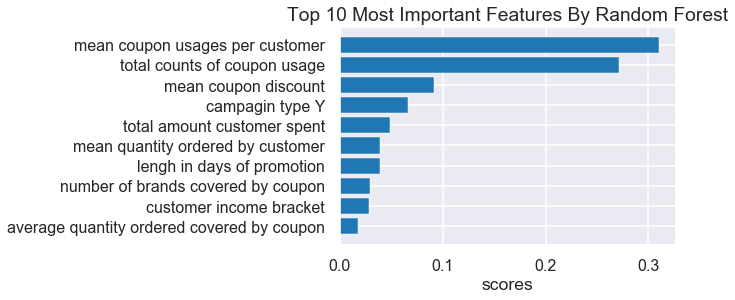

In [82]:
#making new plots with easier names
fig, ax = plt.subplots()
feat_imp = rndforest_feat_imp.score[:10]
ax.barh(np.arange(len(feat_imp)),feat_imp,align ='center')
ax.set_yticks(np.arange(len(feat_imp)))
ax.set_yticklabels(rndforest_feat_imp.replace(feature_names).feature[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('scores')
ax.set_title('Top 10 most important features by Random Forest'.title())

plt.show()
# plt.ylabel('Feature Importance Score')

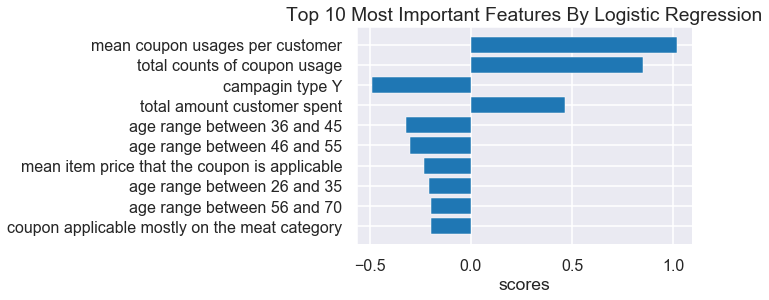

In [86]:
#making new plots with easier names
fig, ax = plt.subplots()
feat_imp = LogReg_FtImp.importance[:10]
ax.barh(np.arange(len(feat_imp)),feat_imp,align ='center')
ax.set_yticks(np.arange(len(feat_imp)))
ax.set_yticklabels(LogReg_FtImp.replace(feature_names).feature[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('scores')
ax.set_title('Top 10 most important features by logistic regression'.title())

plt.show()
# plt.ylabel('Feature Importance Score')

Confusion matrix, without normalization
[[15439    51]
 [ 3691   113]]


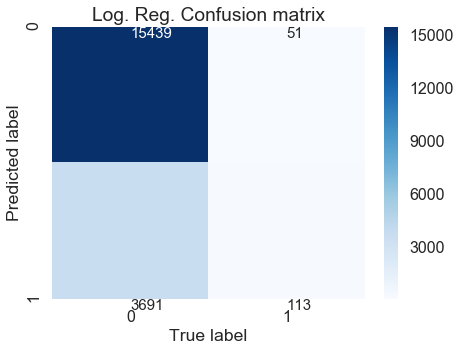

array([[15439,    51],
       [ 3691,   113]], dtype=int64)

In [238]:
plot_confusion_matrix(Log_reg.__dict__['preds']['test_preds'],
                          normalize=False,
                          title='Log. Reg. Confusion matrix',
                          cmap=plt.cm.Blues)

Confusion matrix, without normalization
[[18452    87]
 [  678    77]]


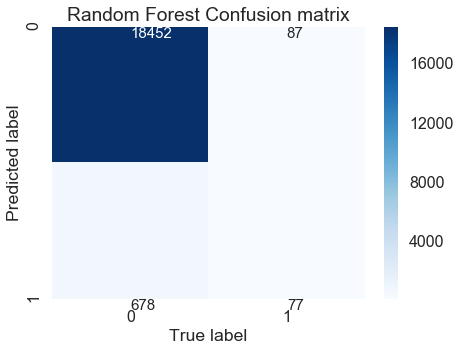

array([[18452,    87],
       [  678,    77]], dtype=int64)

In [239]:
plot_confusion_matrix(rndforest.__dict__['preds']['test_preds'],
                          normalize=False,
                          title='Random Forest Confusion matrix',
                          cmap=plt.cm.Blues)

Confusion matrix, without normalization
[[19039   141]
 [   91    23]]


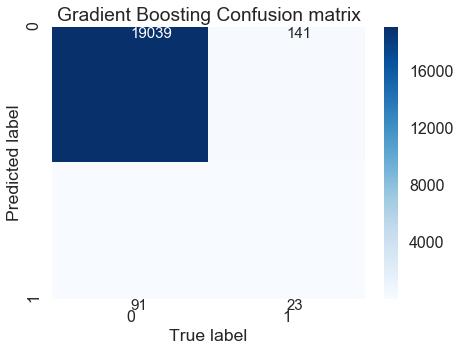

array([[19039,   141],
       [   91,    23]], dtype=int64)

In [242]:
plot_confusion_matrix(gradBoost.__dict__['preds']['test_preds'],
                          normalize=False,
                          title='Gradient Boosting Confusion matrix',
                          cmap=plt.cm.Blues)

### Analysis of results

In [90]:
train_final = datas['train_final']

In [91]:
train_final.age_range.unique()

array(['46-55', '36-45', 'unknown', '18-25', '26-35', '56-70', '70+'],
      dtype=object)

In [92]:
cp_not_used=train_final[train_final.redemption_status==0]
cp_used=train_final[train_final.redemption_status==1]

In [93]:
cp_not_used.age_range.value_counts().to_dict()

{'unknown': 34547,
 '46-55': 14935,
 '36-45': 11061,
 '26-35': 7915,
 '56-70': 3674,
 '70+': 3067,
 '18-25': 2441}

In [94]:
cp_used.age_range.value_counts().to_dict()

{'46-55': 219,
 'unknown': 161,
 '36-45': 149,
 '26-35': 109,
 '56-70': 49,
 '70+': 27,
 '18-25': 15}

In [95]:
cp_used_age_ct = [15,109,149,219,49,27]
cp_not_used_age_ct =[2441,7915,11061,14935,3674,3067]
age_keys =['18-25', '26-35','36-45','46-55', '56-70','70+']

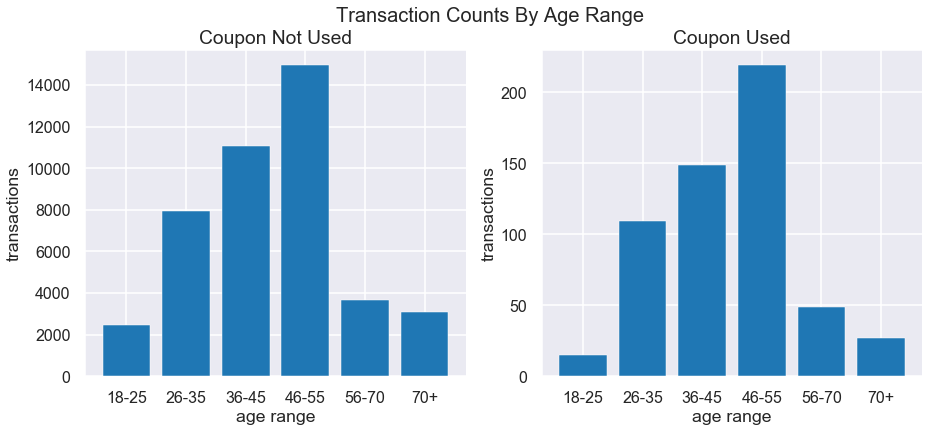

In [96]:
fig, axes = plt.subplots(1,2, figsize =(15,6))

axes[0].bar(age_keys,cp_not_used_age_ct,align ='center')
axes[0].set_ylabel('transactions')
axes[0].set_xlabel('age range')
axes[0].set_title('coupon not used'.title())

axes[1].bar(age_keys,cp_used_age_ct,align ='center')
axes[1].set_ylabel('transactions')
axes[1].set_xlabel('age range')
axes[1].set_title('coupon used'.title())


plt.suptitle('transaction counts by age range'.title(), fontsize = 20)
plt.show()
# plt.ylabel('Feature Importance Score')

In [100]:
not_redeemed.income_bracket.unique()

array([ 5.,  3.,  7.,  1.,  4., 10.,  6., 11.,  2.,  8., 12.,  9.])

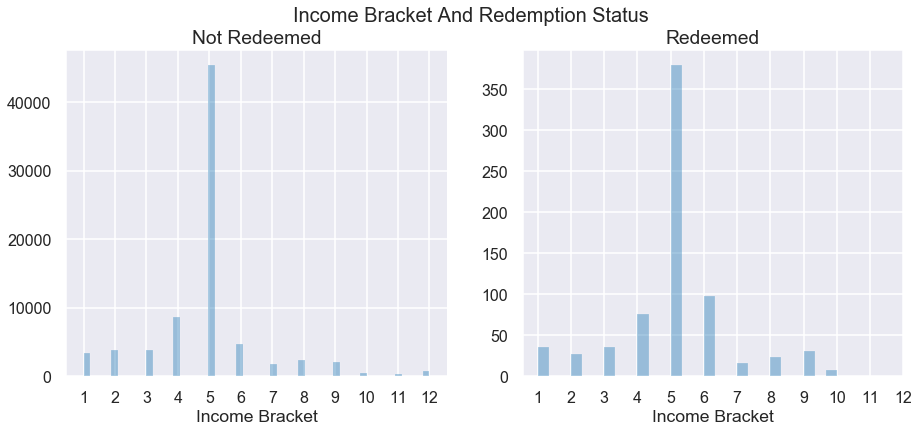

In [109]:
not_redeemed = train_final[train_final.redemption_status ==0]
redeemed = train_final[train_final.redemption_status ==1]
fig, axes = plt.subplots(1,2, figsize =(15,6))
sns.distplot(not_redeemed[['income_bracket']], hist=True, rug=False,kde=False, ax=axes[0])
axes[0].set_title('Not Redeemed')
axes[0].set_xticks(range(1,13,1))
axes[0].set_xlabel('Income Bracket')
sns.distplot(redeemed[['income_bracket']], hist=True, rug=False,kde=False, ax= axes[1])
axes[1].set_title('Redeemed')
axes[1].set_xticks(range(1,13,1))
axes[1].set_xlabel('Income Bracket')
plt.suptitle('Income bracket and redemption status'.title(),fontsize = 20)
plt.show()

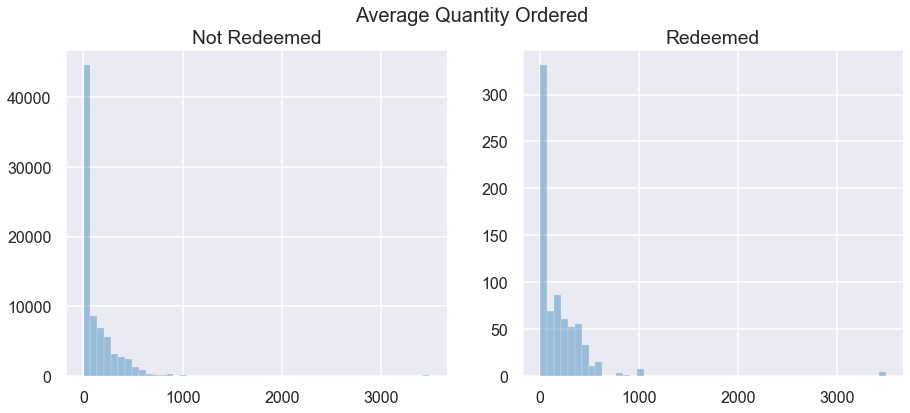

In [112]:
not_redeemed = train_final[train_final.redemption_status ==0]
redeemed = train_final[train_final.redemption_status ==1]
fig, axes = plt.subplots(1,2, figsize =(15,6))
sns.distplot(not_redeemed[['avg_qnt_cust']], hist=True, rug=False,kde=False, ax=axes[0])
axes[0].set_title('Not Redeemed')

sns.distplot(redeemed[['avg_qnt_cust']], hist=True, rug=False,kde=False, ax= axes[1])
axes[1].set_title('Redeemed')

plt.suptitle('average quantity ordered'.title(), fontsize=20)
plt.show()

Text(0.5, 0.98, 'Promotion Length')

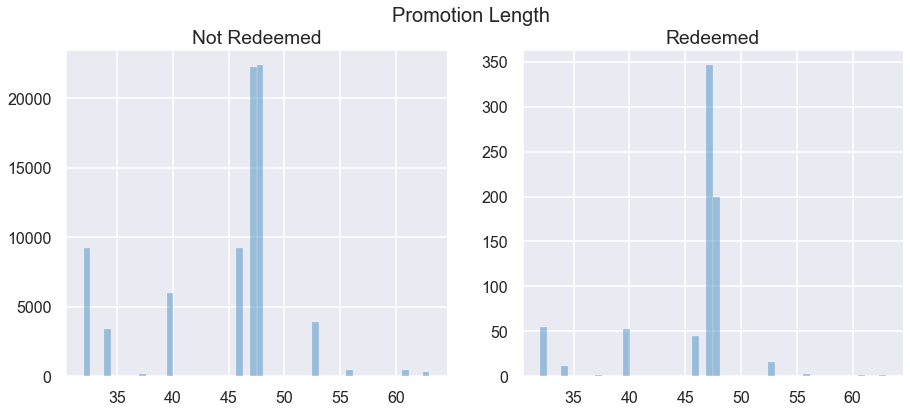

In [113]:
not_redeemed = train_final[train_final.redemption_status ==0]
redeemed = train_final[train_final.redemption_status ==1]
fig, axes = plt.subplots(1,2, figsize =(15,6))
sns.distplot(not_redeemed[['duration_days']], hist=True, rug=False,kde=False, ax=axes[0])
axes[0].set_title('Not Redeemed')
sns.distplot(redeemed[['duration_days']], hist=True, rug=False,kde=False, ax= axes[1])
axes[1].set_title('Redeemed')
plt.suptitle('promotion length'.title(), fontsize=20)

Text(0.5, 0.98, 'Promotion Length In Days')

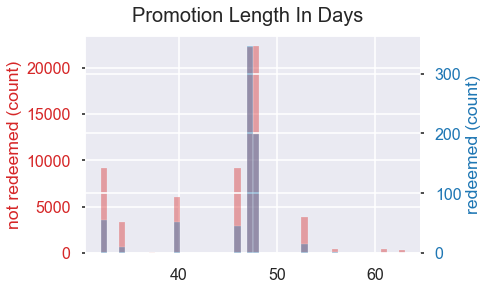

In [155]:
not_redeemed = train_final[train_final.redemption_status ==0]
redeemed = train_final[train_final.redemption_status ==1]
fig, ax1 = plt.subplots()
sns.distplot(not_redeemed[['duration_days']], hist=True, rug=False,kde=False, ax=ax1, color = color1, label='not redeemed')
color1 ='tab:red'
ax1.set_ylabel('not redeemed (count)', color=color1)  # we already handled the x-label with ax1
# sns.distplot(redeemed[['duration_days']], hist=True, rug=False,kde=False, ax= ax1, color= color)
# ax2.plot(t, data2, color=color)
ax1.tick_params(axis='y', labelcolor=color1)



ax2 = ax1.twinx()
color ='tab:blue'
ax2.set_ylabel('redeemed (count)', color=color)  # we already handled the x-label with ax1
sns.distplot(redeemed[['duration_days']], hist=True, rug=False,kde=False, ax= ax2, color= color, label='redeemed')
# ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.suptitle('promotion length in days'.title(), fontsize=20)


### Campaign type

In [79]:
len(train_final[train_final['campaign_type']=='X'].campaign_id.unique())

4

In [78]:
len(train_final[train_final['campaign_type']=='Y'].campaign_id.unique())

14

There are 4 X type campaigns and 14 Y type campaigns

In [116]:
Y_type=train_final[train_final.campaign_type == 'Y'].redemption_status.value_counts()
X_type =train_final[train_final.campaign_type == 'X'].redemption_status.value_counts()
cp_used = [int(Y_type[1]/14), int(X_type[1]/4)]
cp_not_used =[int(Y_type[0]/14), int(X_type[0]/4)]
age_keys =['Y', 'X']

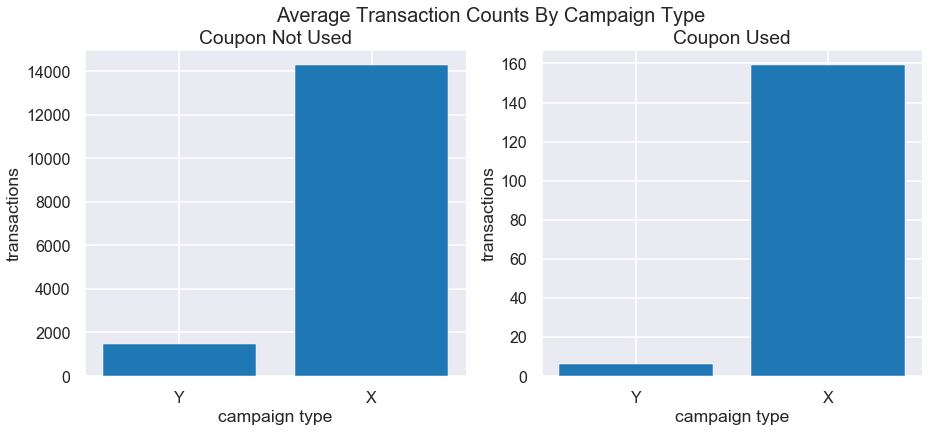

In [117]:
fig, axes = plt.subplots(1,2, figsize =(15,6))

axes[0].bar(age_keys,cp_not_used,align ='center')
axes[0].set_ylabel('transactions')
axes[0].set_xlabel('campaign type')
axes[0].set_title('coupon not used'.title())

axes[1].bar(age_keys,cp_used,align ='center')
axes[1].set_ylabel('transactions')
axes[1].set_xlabel('campaign type')
axes[1].set_title('coupon used'.title())
# ax.set_yticks(np.arange(len(feat_imp)))
# ax.set_yticklabels(rndforest_feat_imp.replace(feature_names).replace(feature_names2).feature[:10])
# ax.invert_yaxis()  # labels read top-to-bottom

# ax.set_title('Top 10 most important features by random forest'.title())
plt.suptitle('average transaction counts by campaign type'.title(), fontsize = 20)
plt.show()
# plt.ylabel('Feature Importance Score')

In [76]:
RNDforest.fit(X_train, y_train)
y_train_hat = RNDforest.predict(X_train)
y_test_hat = RNDforest.predict(X_test)
print_metrics(y_train_hat, y_test_hat)


Train set

Precision Score: 0.8904057435004895
Recall Score: 0.8654578134912244
Accuracy Score: 0.9401888772298006
F1 Score: 0.8777545439922794


Test set

Precision Score: 0.09445843828715365
Recall Score: 0.4573170731707317
Accuracy Score: 0.9581216958639992
F1 Score: 0.15657620041753653




In [90]:
X_test = Results['data_sets']['X_test']
y_train = Results['data_sets']['y_train']
y_test = Results['data_sets']['y_test']

In [80]:
train_final.campaign_type.value_counts()

X    57684
Y    20685
Name: campaign_type, dtype: int64

As the data we are using for modeling is scaled, the values in `campaign_type_Y` is not 0 and 1 but some strange values. 
So the dataset before scaling was referred.

In [118]:
X_train_resampled = datas['X_train_resampled']

In [119]:
X_train_resampled.campaign_type_Y.value_counts()

0    60569
1    15671
Name: campaign_type_Y, dtype: int64

In [81]:
X_train.campaign_type_Y.value_counts()

-0.508655    60569
 1.965970    15671
Name: campaign_type_Y, dtype: int64

In [92]:
X_test = Results['data_sets']['X_test']

In [103]:
X_test.campaign_type_Y.value_counts()

-0.508655    14207
 1.965970     5087
Name: campaign_type_Y, dtype: int64

If the campaign type is changed X from Y, how does the coupon redemption changes? 

In [104]:
X_test_allX = X_test.copy()
X_test_allX['campaign_type_Y']=-0.508655

The random forest model was used to predict this. 

In [105]:
y_test_allX = RNDforest.predict(X_test_allX)

In [107]:
sum(y_test_allX)

1246

In [109]:
sum(y_test_allX)/len(y_test_allX)*100

6.457966207111018

In [111]:
sum(y_test)

164

In [110]:
sum(y_test)/len(y_test)*100

0.8500051829584326

The coupon redemption rate changes from 0.85% to 6.5%!! 

In [120]:
(1246-164)/164*100

659.7560975609756

That is 660% increase 

In [131]:
logreg = LogisticRegression(fit_intercept=False, C=0.001, solver='sag')
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
y_test_allX_Log= logreg.predict(X_test_allX)

In [134]:
y_test_Log = logreg.predict(X_test)

In [135]:
y_test_Log.sum()

3803

In [133]:
y_test_allX_Log.sum()

5334

In [122]:
(5334-3803)/3803*100

40.25769129634499

Using the logistic regression model, the increase is still over 40%.

To read more analysis please read my blog article. 

# Saving the result

In [9]:
Results.keys()

dict_keys(['data_sets', 'Log_reg', 'train_scores', 'test_scores', 'LogReg_FtImp', 'rndforest_tuning', 'rndforest', 'gradBoost', 'agg_preds', 'gradBoost_feat_imp', 'rndforest_feat_imp'])

In [8]:
pickle.dump(Results,open('Results_new.p','rb'))